# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from random import randrange
import scipy

import librosa # For analyzing audio and music, extracting the data from the audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio # To play the audio files

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import concurrent.futures

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Datasets
We will use 4 datasets:
- Crema
- Ravdess
- Savee
- Tess

## RAVDESS Dataset

In [2]:
Ravdess = "../data/input/Ravdess/audio_speech_actors_01-24"

# List directories in the RAVDESS dataset path
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # List files for each actor in the directory
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0].split('-')
        # Third part in each file represents the emotion associated to that file
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# Create a dataframe for emotions of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a dataframe for paths of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace integer labels with actual emotion names
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

# Display the first few rows of the dataframe
Ravdess_df.head(20)

Emotions                                               Path
0   neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
1   neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
2   neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
3   neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
4      calm  ../data/input/Ravdess/audio_speech_actors_01-2...
5      calm  ../data/input/Ravdess/audio_speech_actors_01-2...
6      calm  ../data/input/Ravdess/audio_speech_actors_01-2...
7      calm  ../data/input/Ravdess/audio_speech_actors_01-2...
8      calm  ../data/input/Ravdess/audio_speech_actors_01-2...
9      calm  ../data/input/Ravdess/audio_speech_actors_01-2...
10     calm  ../data/input/Ravdess/audio_speech_actors_01-2...
11     calm  ../data/input/Ravdess/audio_speech_actors_01-2...
12    happy  ../data/input/Ravdess/audio_speech_actors_01-2...
13    happy  ../data/input/Ravdess/audio_speech_actors_01-2...
14    happy  ../data/input/Ravdess/audio_speech_actors_01-2...
15    happy  ../data/input/Ravdess/audio_speech_actors_01-2...
16    happy  ../data/input/Ravdess/audio_speech_actors_01-2...
17    happy  ../data/input/Ravdess/audio_speech_actors_01-2...
18    happy  ../data/input/Ravdess/audio_speech_actors_01-2...
19    happy  ../data/input/Ravdess/audio_speech_actors_01-2...

## CREMA Dataset

In [3]:
Crema = "../data/input/Crema"

# List directories in the CREMA dataset path
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Crema, file))
    # Storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Crema_df.head(20)

Emotions                                     Path
0     angry  ../data/input/Crema\1001_DFA_ANG_XX.wav
1   disgust  ../data/input/Crema\1001_DFA_DIS_XX.wav
2      fear  ../data/input/Crema\1001_DFA_FEA_XX.wav
3     happy  ../data/input/Crema\1001_DFA_HAP_XX.wav
4   neutral  ../data/input/Crema\1001_DFA_NEU_XX.wav
5       sad  ../data/input/Crema\1001_DFA_SAD_XX.wav
6     angry  ../data/input/Crema\1001_IEO_ANG_HI.wav
7     angry  ../data/input/Crema\1001_IEO_ANG_LO.wav
8     angry  ../data/input/Crema\1001_IEO_ANG_MD.wav
9   disgust  ../data/input/Crema\1001_IEO_DIS_HI.wav
10  disgust  ../data/input/Crema\1001_IEO_DIS_LO.wav
11  disgust  ../data/input/Crema\1001_IEO_DIS_MD.wav
12     fear  ../data/input/Crema\1001_IEO_FEA_HI.wav
13     fear  ../data/input/Crema\1001_IEO_FEA_LO.wav
14     fear  ../data/input/Crema\1001_IEO_FEA_MD.wav
15    happy  ../data/input/Crema\1001_IEO_HAP_HI.wav
16    happy  ../data/input/Crema\1001_IEO_HAP_LO.wav
17    happy  ../data/input/Crema\1001_IEO_HAP_MD.wav
18  neutral  ../data/input/Crema\1001_IEO_NEU_XX.wav
19      sad  ../data/input/Crema\1001_IEO_SAD_HI.wav

## TESS Dataset

In [4]:
Tess = "../data/input/Tess"

# List directories in the TESS dataset path
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0].split('_')[2]
        # Handle the 'ps' for surprise, if it is there
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part.lower())  # Convert to lowercase for consistency
        file_path.append(os.path.join(Tess, dir, file))

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Tess_df.head(30)

Emotions                                               Path
0     angry    ../data/input/Tess\OAF_angry\OAF_back_angry.wav
1     angry     ../data/input/Tess\OAF_angry\OAF_bar_angry.wav
2     angry    ../data/input/Tess\OAF_angry\OAF_base_angry.wav
3     angry    ../data/input/Tess\OAF_angry\OAF_bath_angry.wav
4     angry    ../data/input/Tess\OAF_angry\OAF_bean_angry.wav
5     angry     ../data/input/Tess\OAF_angry\OAF_beg_angry.wav
6     angry    ../data/input/Tess\OAF_angry\OAF_bite_angry.wav
7     angry    ../data/input/Tess\OAF_angry\OAF_boat_angry.wav
8     angry    ../data/input/Tess\OAF_angry\OAF_bone_angry.wav
9     angry    ../data/input/Tess\OAF_angry\OAF_book_angry.wav
10    angry  ../data/input/Tess\OAF_angry\OAF_bought_angry.wav
11    angry    ../data/input/Tess\OAF_angry\OAF_burn_angry.wav
12    angry     ../data/input/Tess\OAF_angry\OAF_cab_angry.wav
13    angry    ../data/input/Tess\OAF_angry\OAF_calm_angry.wav
14    angry    ../data/input/Tess\OAF_angry\OAF_came_angry.wav
15    angry   ../data/input/Tess\OAF_angry\OAF_cause_angry.wav
16    angry   ../data/input/Tess\OAF_angry\OAF_chain_angry.wav
17    angry   ../data/input/Tess\OAF_angry\OAF_chair_angry.wav
18    angry   ../data/input/Tess\OAF_angry\OAF_chalk_angry.wav
19    angry    ../data/input/Tess\OAF_angry\OAF_chat_angry.wav
20    angry   ../data/input/Tess\OAF_angry\OAF_check_angry.wav
21    angry   ../data/input/Tess\OAF_angry\OAF_cheek_angry.wav
22    angry   ../data/input/Tess\OAF_angry\OAF_chief_angry.wav
23    angry  ../data/input/Tess\OAF_angry\OAF_choice_angry.wav
24    angry    ../data/input/Tess\OAF_angry\OAF_cool_angry.wav
25    angry     ../data/input/Tess\OAF_angry\OAF_dab_angry.wav
26    angry    ../data/input/Tess\OAF_angry\OAF_date_angry.wav
27    angry    ../data/input/Tess\OAF_angry\OAF_dead_angry.wav
28    angry   ../data/input/Tess\OAF_angry\OAF_death_angry.wav
29    angry    ../data/input/Tess\OAF_angry\OAF_deep_angry.wav

## SAVEE Dataset

In [5]:
Savee = "../data/input/Savee"

# List directories in the SAVEE dataset path
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Savee, file))
    # Storing file emotions
    part = file.split('_')[1]
    ele = part[:2] if part.startswith('s') else part[0]
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    elif ele == 'su':
        file_emotion.append('surprise')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Savee_df.head(20)

Emotions                            Path
0     angry  ../data/input/Savee\DC_a01.wav
1     angry  ../data/input/Savee\DC_a02.wav
2     angry  ../data/input/Savee\DC_a03.wav
3     angry  ../data/input/Savee\DC_a04.wav
4     angry  ../data/input/Savee\DC_a05.wav
5     angry  ../data/input/Savee\DC_a06.wav
6     angry  ../data/input/Savee\DC_a07.wav
7     angry  ../data/input/Savee\DC_a08.wav
8     angry  ../data/input/Savee\DC_a09.wav
9     angry  ../data/input/Savee\DC_a10.wav
10    angry  ../data/input/Savee\DC_a11.wav
11    angry  ../data/input/Savee\DC_a12.wav
12    angry  ../data/input/Savee\DC_a13.wav
13    angry  ../data/input/Savee\DC_a14.wav
14    angry  ../data/input/Savee\DC_a15.wav
15  disgust  ../data/input/Savee\DC_d01.wav
16  disgust  ../data/input/Savee\DC_d02.wav
17  disgust  ../data/input/Savee\DC_d03.wav
18  disgust  ../data/input/Savee\DC_d04.wav
19  disgust  ../data/input/Savee\DC_d05.wav

## Combined Datasets

In [7]:
# Combining datasets into one dataframe
data_df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_df.head()

Emotions                                               Path
0  neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
1  neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
2  neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
3  neutral  ../data/input/Ravdess/audio_speech_actors_01-2...
4     calm  ../data/input/Ravdess/audio_speech_actors_01-2...

In [8]:
# Checking label counts
data_df.Emotions.value_counts()

Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

In [9]:
# Combining neutral and calm instances
data_df.loc[data_df['Emotions'] == 'neutral','Emotions'] = "calm"

In [10]:
# Checking label counts
data_df.Emotions.value_counts()

Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1923
calm        1895
surprise     652
Name: count, dtype: int64

In [11]:
# Dataframe info
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12162 entries, 0 to 479
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  12162 non-null  object
 1   Path      12162 non-null  object
dtypes: object(2)
memory usage: 285.0+ KB


# Exploratory Data Analysis

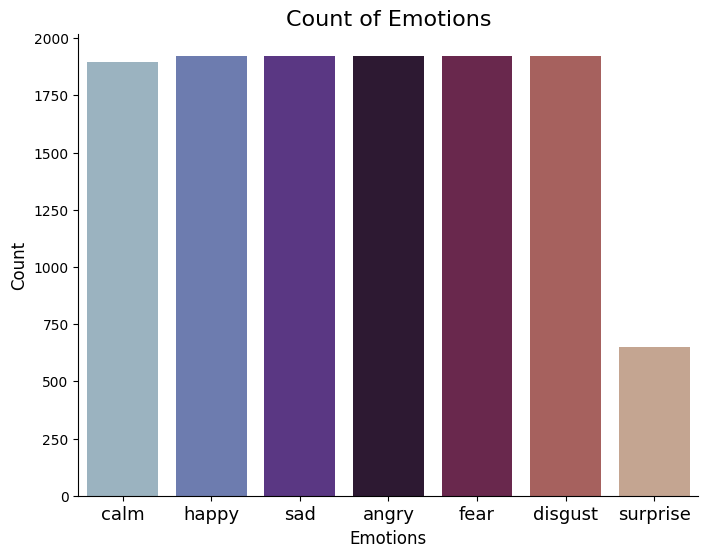

In [12]:
# Plot to see counts of labels
plt.figure(figsize=(8 ,6))
plt.title('Count of Emotions', size=16)
# Google drive plot
sns.countplot(data=data_df, x="Emotions", hue="Emotions", palette="twilight", legend=False)
# Kaggle plot
# sns.countplot(data=data_df, x="Emotions")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tick_params(axis='x', labelsize=13)
plt.show()

Now we will plot waveplots and spectrograms for an instance of each emotion

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectrograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to time for given audio/music signals.

In [13]:
# Function to plot waveform
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Amplitude', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

# Function to plot spectrogram
def create_spectrogram(data, sr, emo):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    # Convert frequency into decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(11, 3))
    plt.title(f'Spectrogram for audio with {emo} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Hz', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.colorbar()

# Combine all plot functions
def combine_plots(data, emo):
    # Randomly select data instance of given emotion
    data_path = data[data['Emotions'] == emo]['Path'].iloc[randrange(len(data[data['Emotions'] == emo]))]
    data, sr = librosa.load(data_path)
    create_waveplot(data, sr, emo)
    create_spectrogram(data, sr, emo)
    return data, sr

## Calm

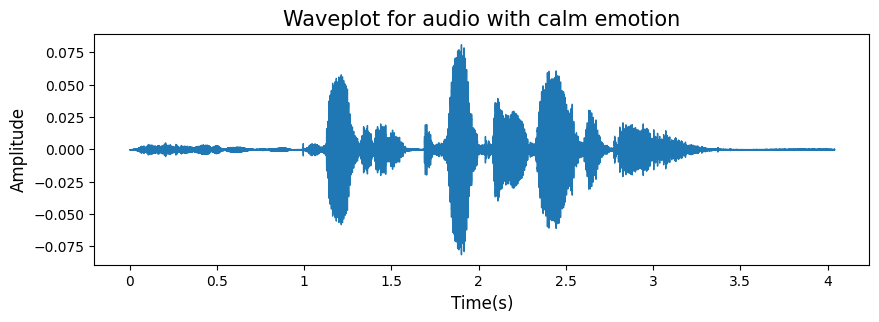

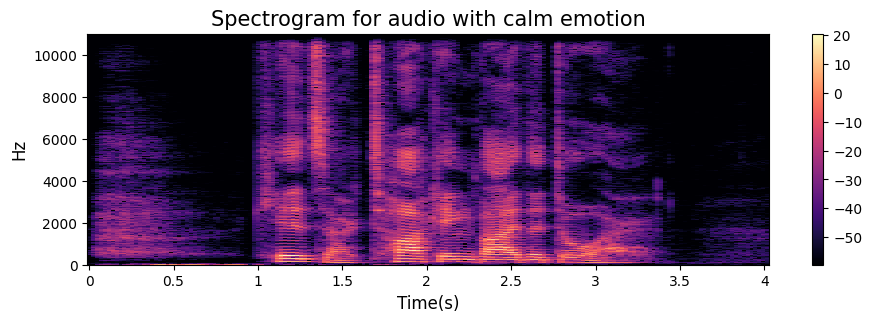

In [14]:
emo = 'calm'
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Surprise

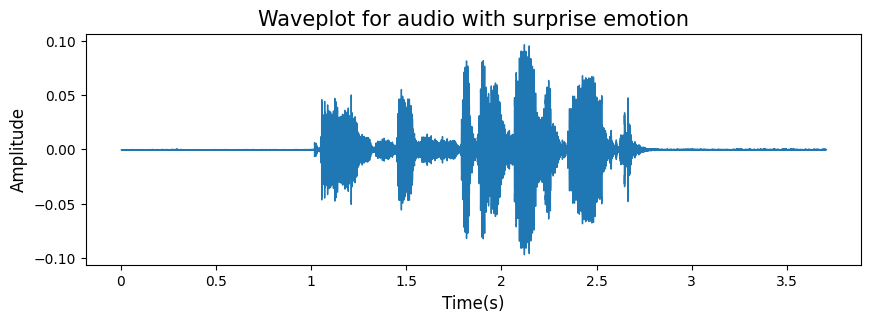

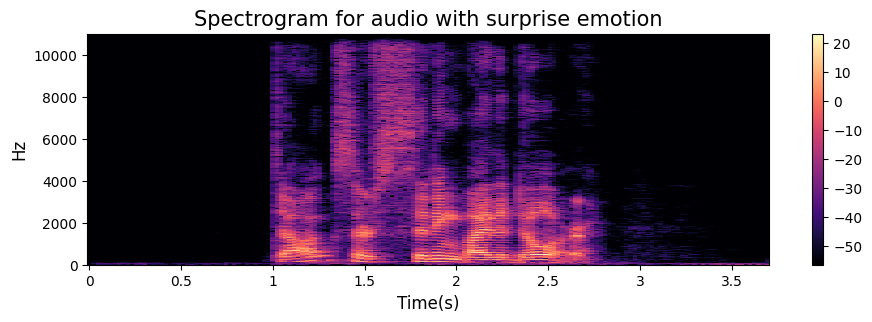

In [15]:
emo = "surprise"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Happy

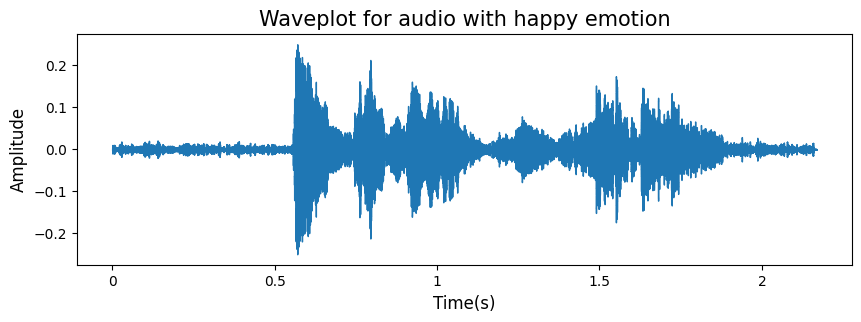

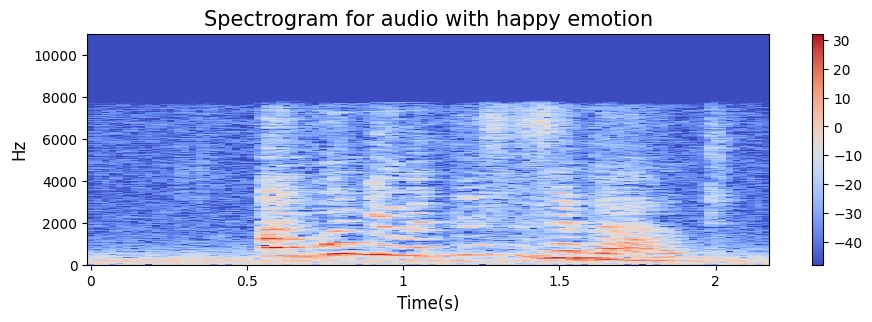

In [16]:
emo = "happy"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Disgust

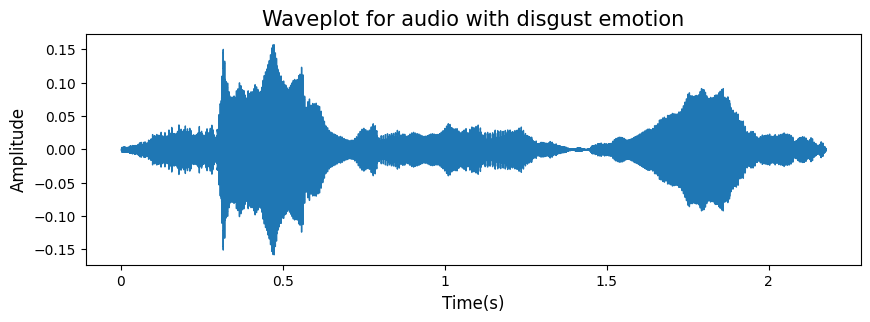

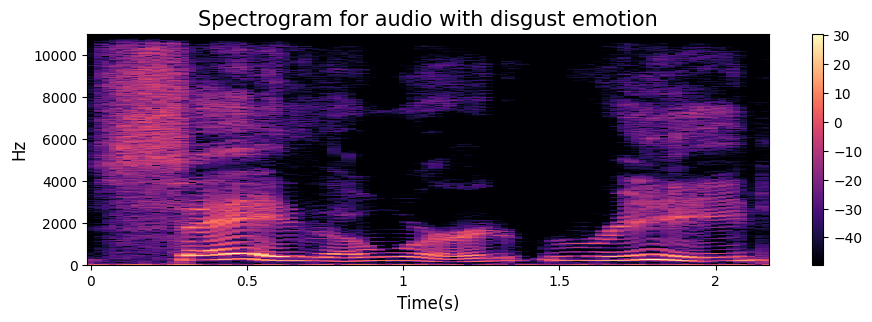

In [17]:
emo = "disgust"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Sad

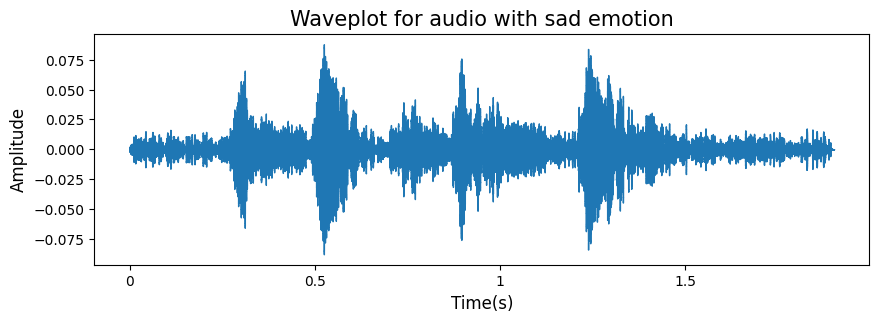

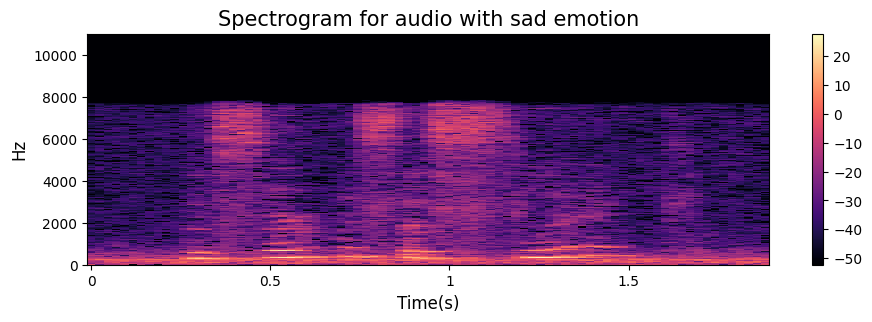

In [18]:
emo = "sad"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Anger

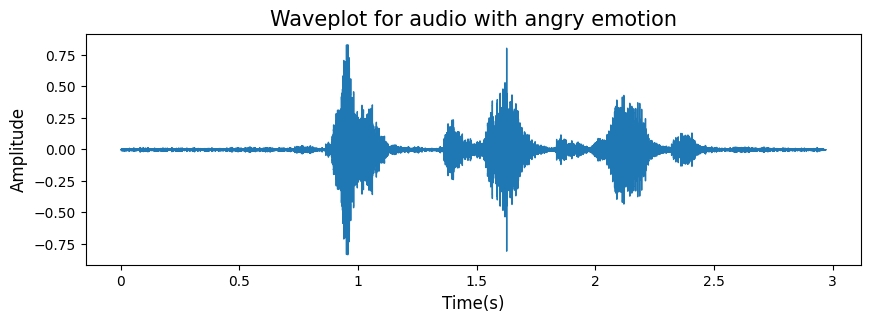

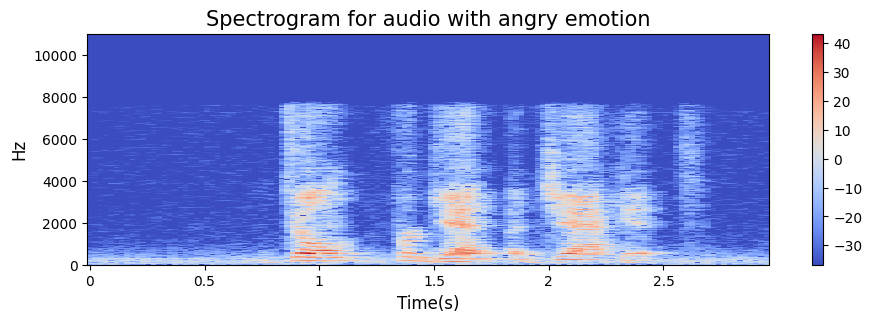

In [19]:
emo = "angry"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Fear

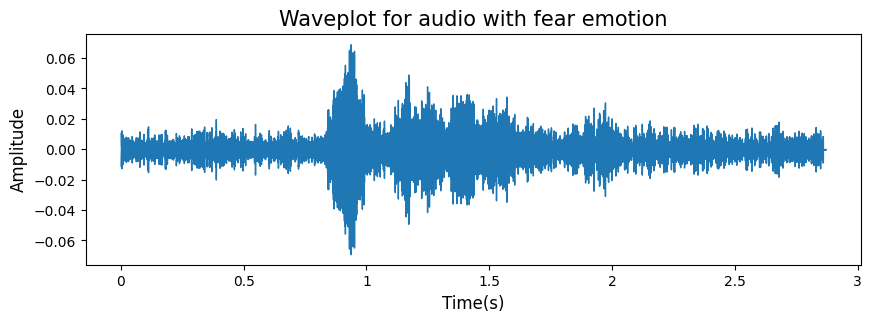

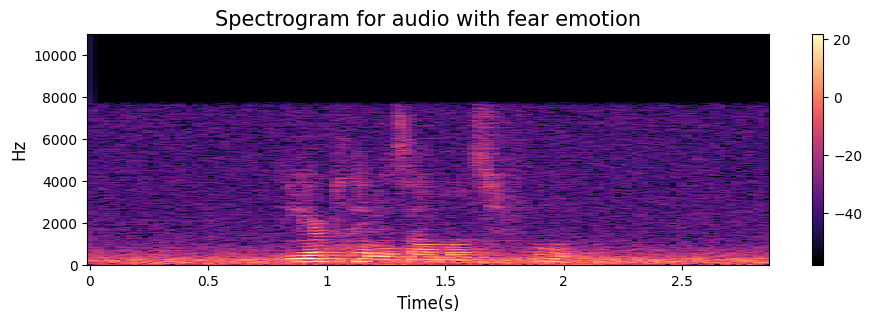

In [20]:
emo = "fear"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

# Data Augmentation

In [21]:
# Function to introduce noise in the audio
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data
# Function to stretch audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Function to change the pitch of the data
def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

In [22]:
# Sample audio path for demonstration
path = data_df['Path'].iloc[randrange(len(data_df))]
data, sample_rate = librosa.load(path)

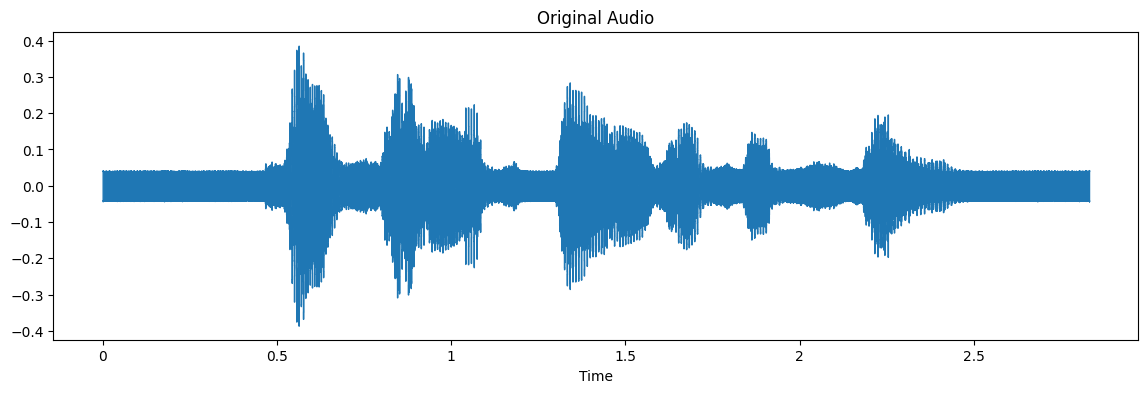

In [23]:
# Simple Audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title('Original Audio')
plt.show()
display(Audio(data, rate=sample_rate))

## Noise Injection

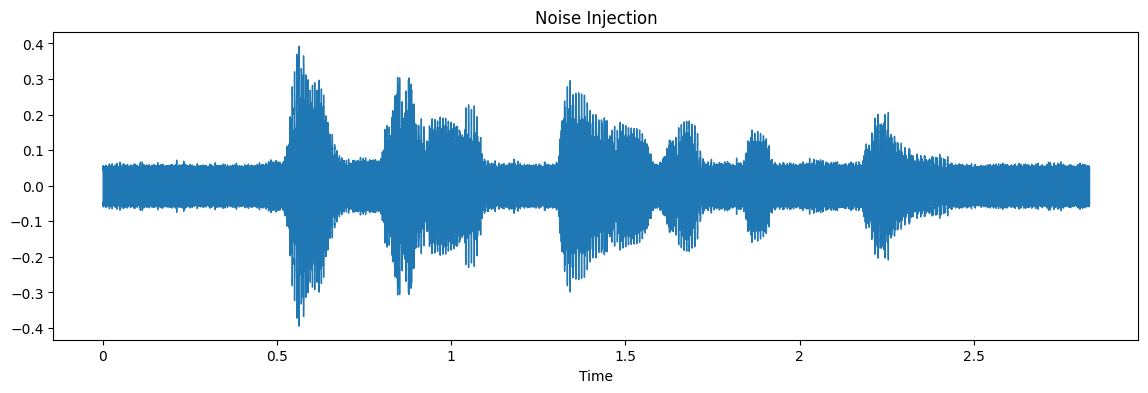

In [24]:
# Introducing noise in audio file
x = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Noise Injection')
plt.show()
Audio(x, rate=sample_rate)

## Stretching

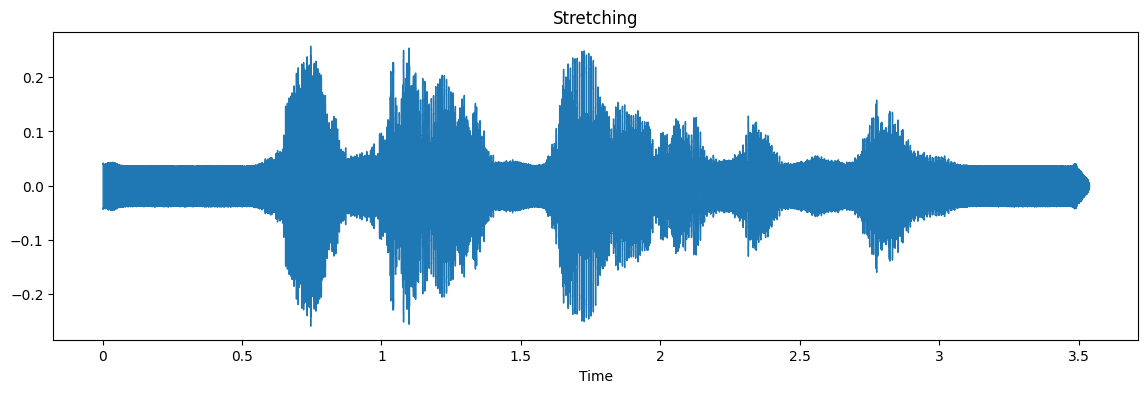

In [25]:
# Stretching the audio file
x = stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Stretching')
plt.show()
display(Audio(x, rate=sample_rate))

## Pitch Shift

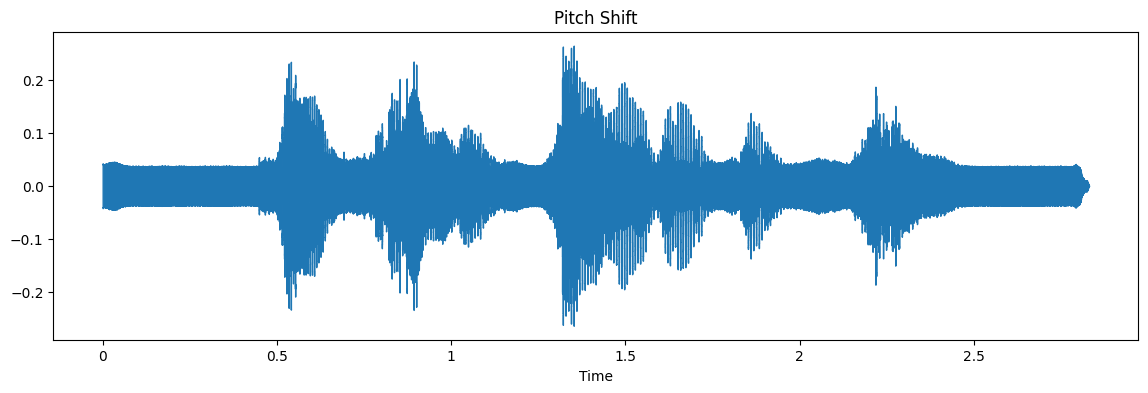

In [26]:
# Shifting the pitch of audio file
x = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Pitch Shift')
plt.show()
display(Audio(x, rate=sample_rate))

# Feature Extraction

We will work with the following features:
* MFCCs: Capture detailed spectral information and are widely used in speech and audio processing.
* Energy and Entropy of Energy: Provide information about the intensity and variability of speech, which are important for detecting emotions.
* Zero Crossing Rate: Useful for distinguishing between different types of speech sounds.
* Mel-Spectrogram: Represents the power spectrum in the mel scale. Captures both temporal and spectral features of the audio signal.
* Spectral Features (Centroid, Spread, Roll-off): Provide a comprehensive description of the spectral characteristics of the speech signal.

In [27]:
# Function to extract features
def extract_features(data, sample_rate):
    # MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    # Energy
    energy = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # Entropy of energy (computed as entropy of the short-term energy)
    st_energy = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    entropy_of_energy = np.mean([scipy.stats.entropy(e) for e in st_energy])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Mel-Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)

    # Spectral Spread
    spectral_spread = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)

    # Spectral Roll-off
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)

    # Concatenate all features
    features = np.hstack((mfcc, energy, entropy_of_energy, zcr, mel, spectral_centroid, spectral_spread, spectral_rolloff))
    return features

# Function to apply extract_features on data
def get_features(path):
  data, sample_rate = librosa.load(path, duration=3, offset=0.3)

  # Simple Audio
  simple = extract_features(data, sample_rate)

  # Noisy audio
  noisy = extract_features(noise(data), sample_rate)

  # Stretching
  stretched = extract_features(stretch(data), sample_rate)

  # Pitch shifting
  pitch_shifted = extract_features(pitch(data, sample_rate), sample_rate)

  # Concatenate
  features = np.vstack((simple, noisy, stretched, pitch_shifted))
  return features

In [28]:
def process_file(path, emotion):
    features = get_features(path)
    return [(feature, emotion) for feature in features]

In [29]:
X, y = [], []
c = 0
# Use ThreadPoolExecutor for I/O bound tasks or ProcessPoolExecutor for CPU bound tasks
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a list of futures
    futures = [executor.submit(process_file, path, emotion) for path, emotion in zip(data_df.Path, data_df.Emotions)]

    # As each future completes, process the results
    for future in concurrent.futures.as_completed(futures):
        results = future.result()
        for feature, emotion in results:
            X.append(feature)
            y.append(emotion)
            c += 1
        print(f"Processed {c} files")

Processed 4 files
Processed 8 files
Processed 12 files
Processed 16 files
Processed 20 files
Processed 24 files
Processed 28 files
Processed 32 files
Processed 36 files
Processed 40 files
Processed 44 files
Processed 48 files
Processed 52 files
Processed 56 files
Processed 60 files
Processed 64 files
Processed 68 files
Processed 72 files
Processed 76 files
Processed 80 files
Processed 84 files
Processed 88 files
Processed 92 files
Processed 96 files
Processed 100 files
Processed 104 files
Processed 108 files
Processed 112 files
Processed 116 files
Processed 120 files
Processed 124 files
Processed 128 files
Processed 132 files
Processed 136 files
Processed 140 files
Processed 144 files
Processed 148 files
Processed 152 files
Processed 156 files
Processed 160 files
Processed 164 files
Processed 168 files
Processed 172 files
Processed 176 files
Processed 180 files
Processed 184 files
Processed 188 files
Processed 192 files
Processed 196 files
Processed 200 files
Processed 204 files
Proces

In [30]:
# Length of features and labels
len(X), len(y)

(48648, 48648)

In [31]:
# Create dataframe of features and labels
data_df = pd.DataFrame(X)
data_df["Labels"] = y
data_df.head()

0          1         2          3         4         5         6  \
0 -617.725708  72.756355 -5.173512  14.475173  4.781723 -3.444918 -6.613452   
1 -381.138989  24.643812  7.184962   6.522421  2.024996 -2.267685 -2.759540   
2 -642.066162  70.932060 -5.411959  15.277938  4.099855 -3.978234 -6.901479   
3 -643.419128  71.162407 -6.236180  16.053551  2.777739 -4.711625 -8.080362   
4 -604.780640  72.718674 -6.795485  17.835999  7.486809 -1.882551 -7.636709   

          7          8         9  ...       145       146       147       148  \
0 -7.742167 -13.384870 -2.829333  ...  0.000008  0.000011  0.000013  0.000010   
1 -5.814789  -7.485220 -4.659278  ...  0.000242  0.000249  0.000248  0.000250   
2 -8.433949 -13.474022 -3.037201  ...  0.000004  0.000005  0.000006  0.000004   
3 -9.430119 -12.850635  0.272254  ...  0.000005  0.000005  0.000003  0.000006   
4 -5.590031 -15.820679 -1.626837  ...  0.000005  0.000003  0.000003  0.000004   

        149           150          151          152          153  Labels  
0  0.000009  9.332945e-07  2811.768925  2482.395870  5478.460975   happy  
1  0.000254  2.311633e-04  4454.113392  3177.236587  8413.270921   happy  
2  0.000004  4.973675e-07  2807.351512  2487.554262  5481.263563   happy  
3  0.000003  1.891041e-07  2790.942549  2485.283905  5501.236478   happy  
4  0.000004  4.155424e-07  2611.242423  2376.580513  5156.208308   happy  

[5 rows x 155 columns]

# Data Preprocessing

In [32]:
# Check for null values
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")

Null values in dataframe: 4
Shape of dataframe: (48648, 155)


In [33]:
# Drop null values
data_df.dropna(inplace=True)
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")

Null values in dataframe: 0
Shape of dataframe: (48644, 155)


In [34]:
# Check value of counts of labels
data_df.Labels.value_counts()

Labels
happy       7692
angry       7692
fear        7692
disgust     7692
sad         7688
calm        7580
surprise    2608
Name: count, dtype: int64

In [35]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [36]:
# Handle imbalanced label "surprise" by creating fake data instances
# Synthetic Minority Over-sampling Technique (SMOTE)

from imblearn.over_sampling import SMOTE
data_df.columns = data_df.columns.astype(str)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(data_df.iloc[:,:-1], data_df["Labels"])

In [37]:
# Check length of resampled data
len(X_resampled), len(y_resampled)

(53844, 53844)

In [38]:
# Recreate dataframe using resampled data
data_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_df.head()

0          1         2          3         4         5         6  \
0 -617.725708  72.756355 -5.173512  14.475173  4.781723 -3.444918 -6.613452   
1 -381.138989  24.643812  7.184962   6.522421  2.024996 -2.267685 -2.759540   
2 -642.066162  70.932060 -5.411959  15.277938  4.099855 -3.978234 -6.901479   
3 -643.419128  71.162407 -6.236180  16.053551  2.777739 -4.711625 -8.080362   
4 -604.780640  72.718674 -6.795485  17.835999  7.486809 -1.882551 -7.636709   

          7          8         9  ...       145       146       147       148  \
0 -7.742167 -13.384870 -2.829333  ...  0.000008  0.000011  0.000013  0.000010   
1 -5.814789  -7.485220 -4.659278  ...  0.000242  0.000249  0.000248  0.000250   
2 -8.433949 -13.474022 -3.037201  ...  0.000004  0.000005  0.000006  0.000004   
3 -9.430119 -12.850635  0.272254  ...  0.000005  0.000005  0.000003  0.000006   
4 -5.590031 -15.820679 -1.626837  ...  0.000005  0.000003  0.000003  0.000004   

        149           150          151          152          153  Labels  
0  0.000009  9.332945e-07  2811.768925  2482.395870  5478.460975   happy  
1  0.000254  2.311633e-04  4454.113392  3177.236587  8413.270921   happy  
2  0.000004  4.973675e-07  2807.351512  2487.554262  5481.263563   happy  
3  0.000003  1.891041e-07  2790.942549  2485.283905  5501.236478   happy  
4  0.000004  4.155424e-07  2611.242423  2376.580513  5156.208308   happy  

[5 rows x 155 columns]

In [39]:
# Check value counts of each label in new dataframe
data_df.Labels.value_counts()

Labels
happy       7692
calm        7692
sad         7692
angry       7692
fear        7692
disgust     7692
surprise    7692
Name: count, dtype: int64

In [43]:
data_df.to_csv("../data/input/combined.csv", index = False)

# Data Preparation

In [45]:
# Import necessary libraries for scaling and splitting
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [46]:
# Preparing the features and labels
X = data_df.iloc[:, :-1].values
y = data_df['Labels'].values

In [47]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [48]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [49]:
# Printing the shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40383, 154) (40383, 7) (13461, 154) (13461, 7)


In [50]:
# Scaling the data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
# Printing the shapes of the scaled data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40383, 154) (40383, 7) (13461, 154) (13461, 7)


# Evaluation functions

In [45]:
# Import required libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
def plot_loss_accuracy_curves(history):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.ylabel("loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [47]:
# Function to calculate and display accuracy, precision, recall, F1 score, and ROC AUC
def display_metrics(model1, X_test, y_test):
    # Predict validation data
    y_test_pred = model1.predict(X_test)
    y_test_pred_class = (y_test_pred > 0.5).astype("int32")

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred_class)
    precision = precision_score(y_test, y_test_pred_class, average='weighted')
    recall = recall_score(y_test, y_test_pred_class, average='weighted')
    f1 = f1_score(y_test, y_test_pred_class, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred)

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

In [48]:
from sklearn.metrics import multilabel_confusion_matrix

# Function to display confusion matrix for multilabel classification
def plot_confusion_matrix(model1, X_test, y_test):
    # Predict validation data
    y_test_pred = model1.predict(X_test)
    y_test_pred_class = (y_test_pred > 0.5).astype("int32")

    # Confusion Matrix
    cm = multilabel_confusion_matrix(y_test, y_test_pred_class)
    for i, matrix in enumerate(cm):
        plt.figure(figsize=(7, 5))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Label {i}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score

# Function to plot ROC curve for multilabel classification
def plot_roc_curve(model1, X_test, y_test):
    y_test_pred = model1.predict(X_test)

    # Plot ROC curve for each label
    for i in range(y_test.shape[1]):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc = roc_auc_score(y_test[:, i], y_test_pred[:, i])
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for label {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for label {i}')
        plt.legend(loc='best')
        plt.show()

# ANN Model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [51]:
model1 = Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

In [52]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
history1 = model1.fit(X_train, y_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train)//32, validation_data=(X_test, y_test), validation_steps=len(X_test))

Epoch 1/100
  92/1261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2373 - loss: 1.8987

I0000 00:00:1720884468.832407      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3780 - loss: 1.5752 - val_accuracy: 0.5150 - val_loss: 1.2515
Epoch 2/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 428us/step - accuracy: 0.5161 - loss: 1.3923 - val_accuracy: 0.5078 - val_loss: 1.2511
Epoch 3/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5218 - loss: 1.2252 - val_accuracy: 0.5663 - val_loss: 1.1018
Epoch 4/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1s 441us/step - accuracy: 0.5484 - loss: 1.1532 - val_accuracy: 0.5718 - val_loss: 1.0948
Epoch 5/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5634 - loss: 1.1081 - val_accuracy: 0.5907 - val_loss: 1.0495
Epoch 6/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - accuracy: 0.6129 - loss: 1.0775 - val_accuracy: 0.5869 - val_loss: 1.0531
Epoch 7/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5851 - loss: 1.0463 - val_accuracy: 0.6052 - val_loss: 1.0121
Epoch 8/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.4516 - loss: 1.089

## Evaluate ANN Model

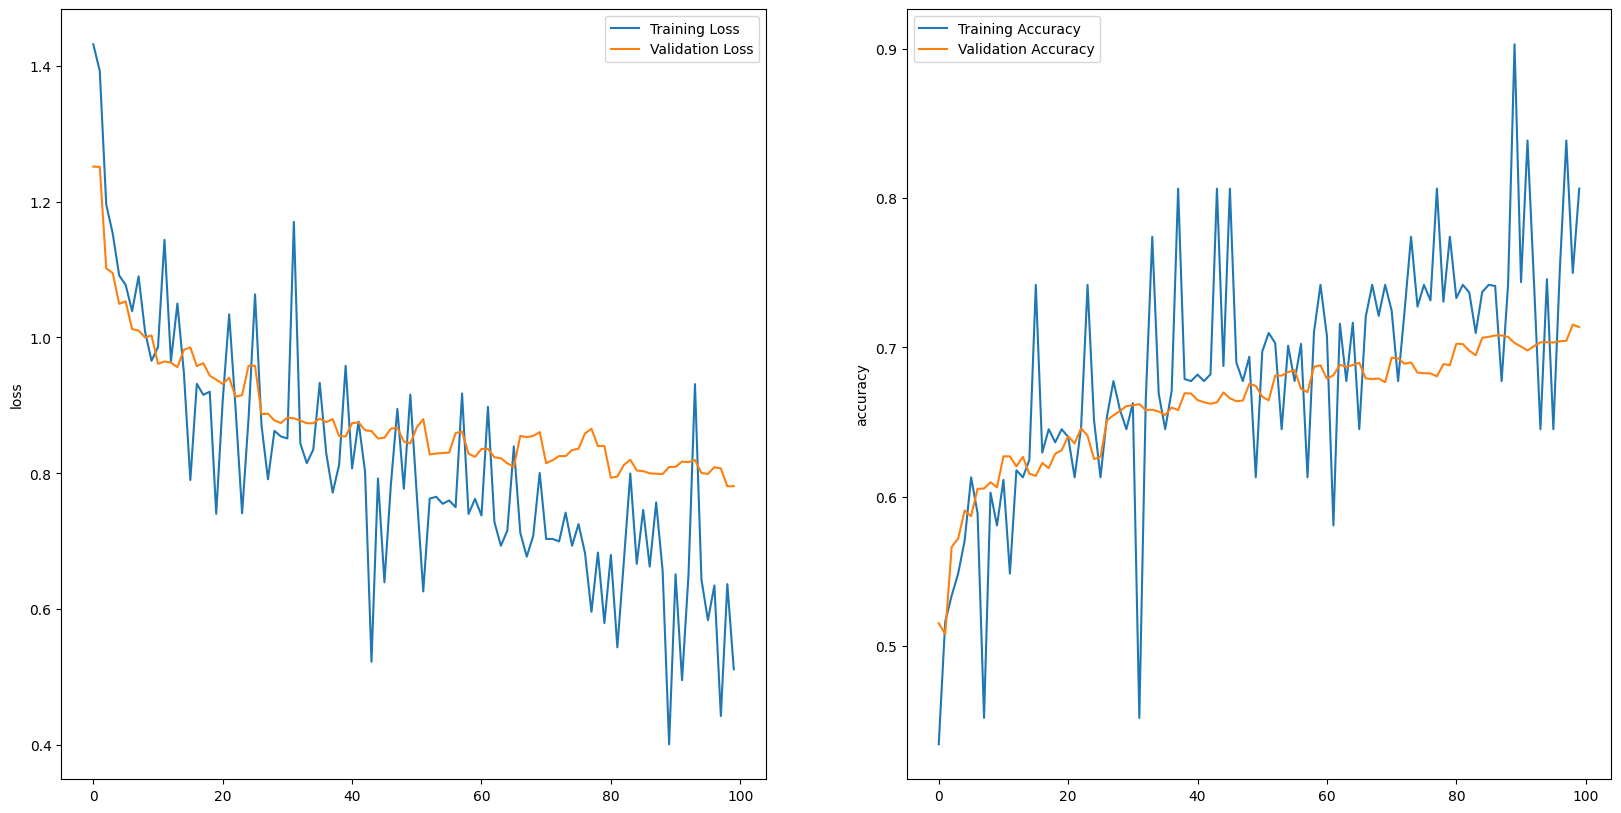

In [54]:
plot_loss_accuracy_curves(history1)

In [55]:
display_metrics(model1, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6250
Precision: 0.8073
Recall: 0.6250
F1 Score: 0.7000
ROC AUC: 0.9443


421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


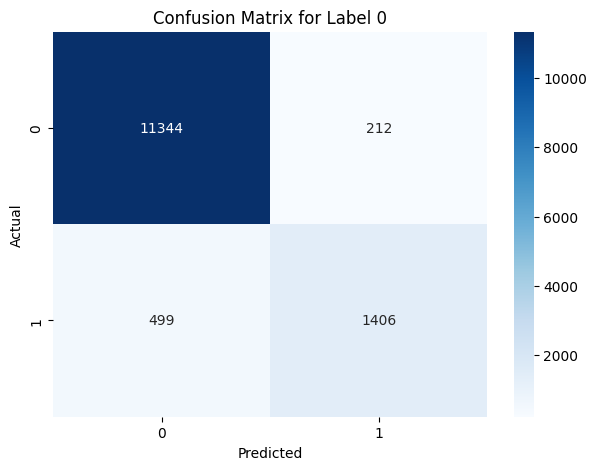

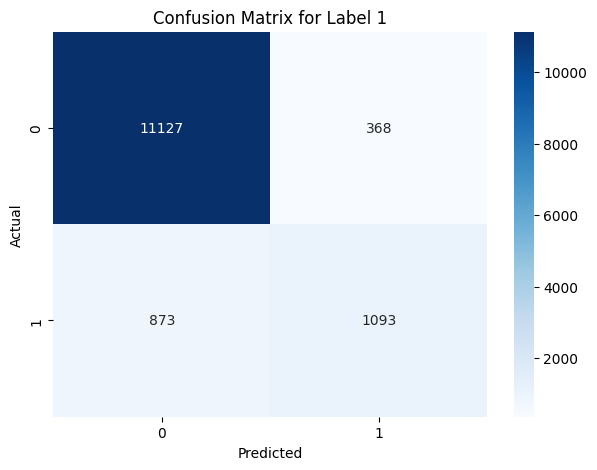

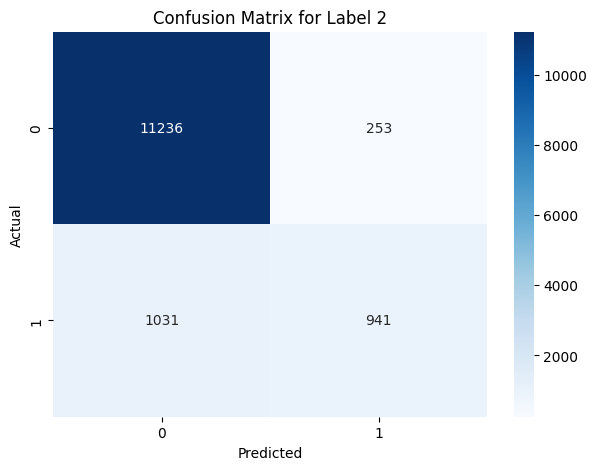

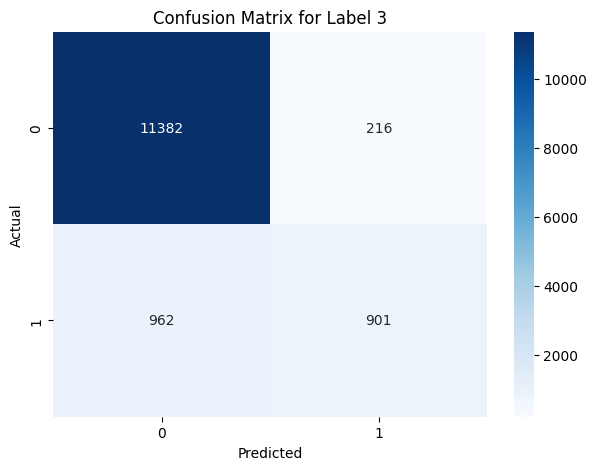

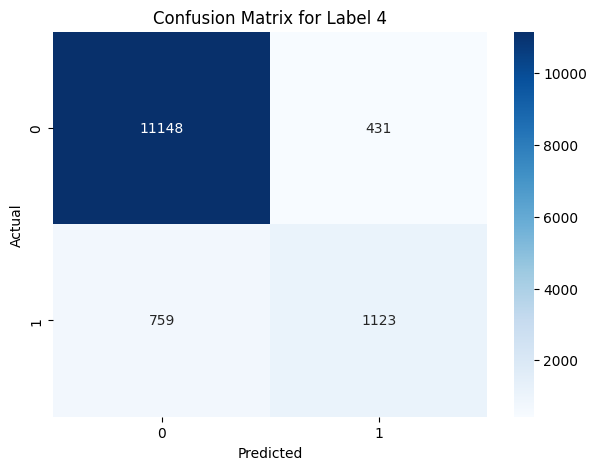

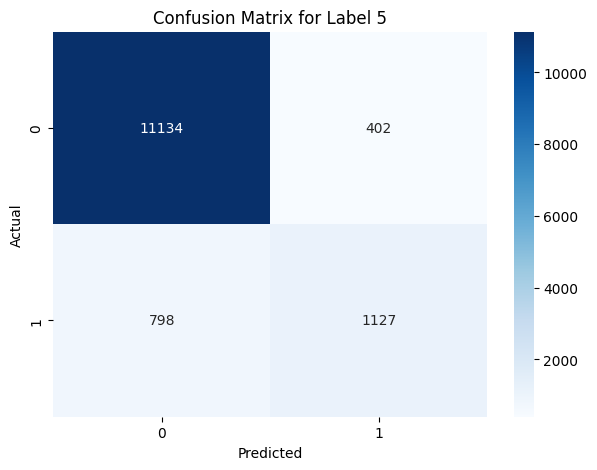

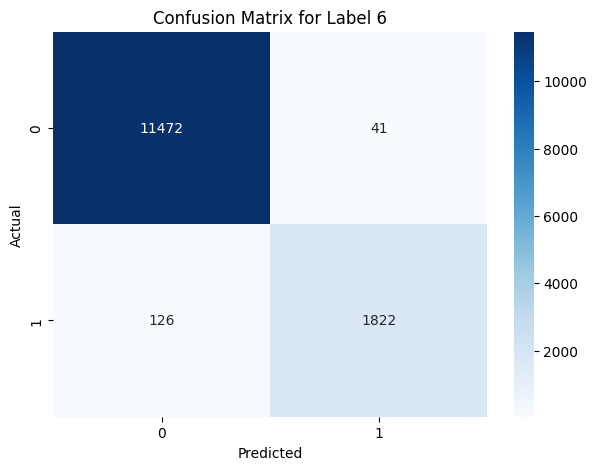

In [56]:
plot_confusion_matrix(model1, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


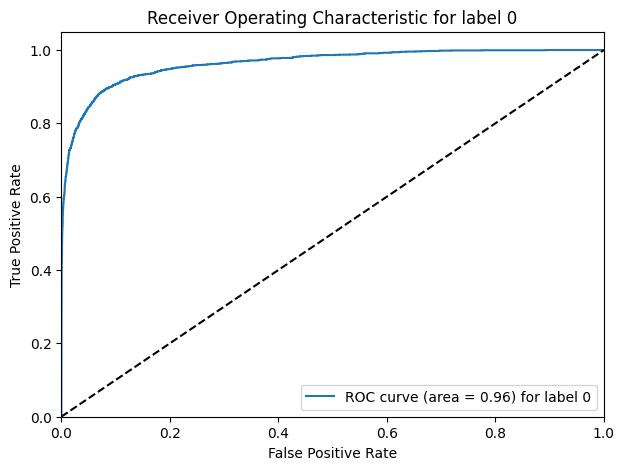

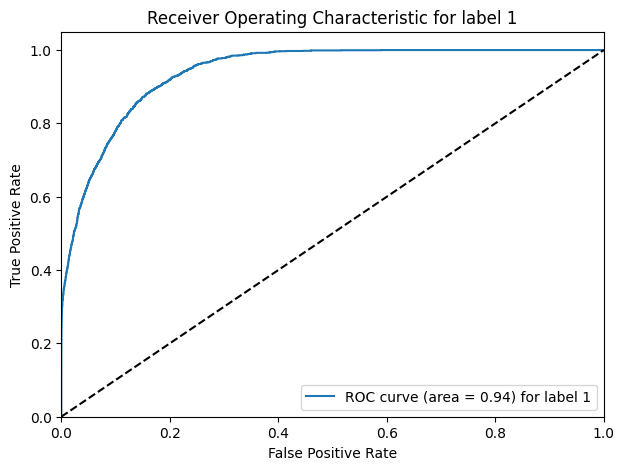

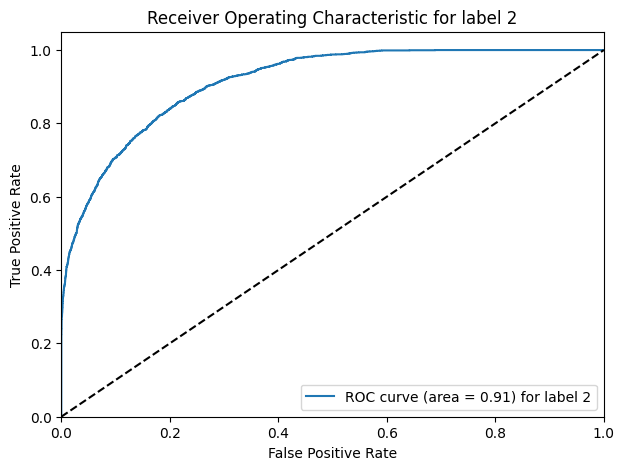

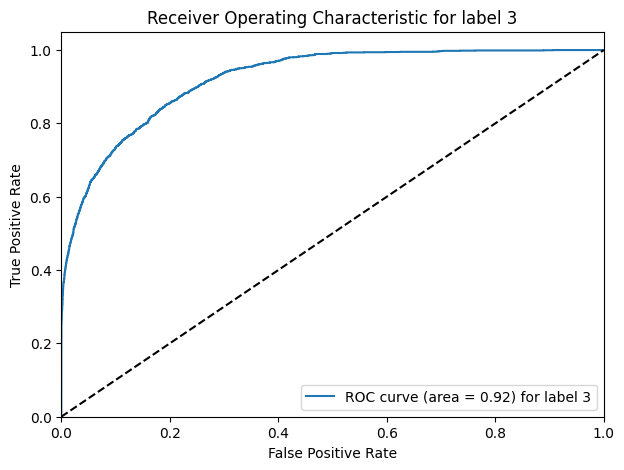

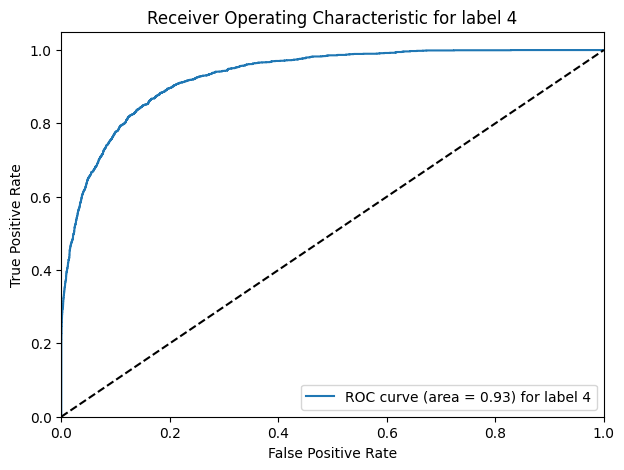

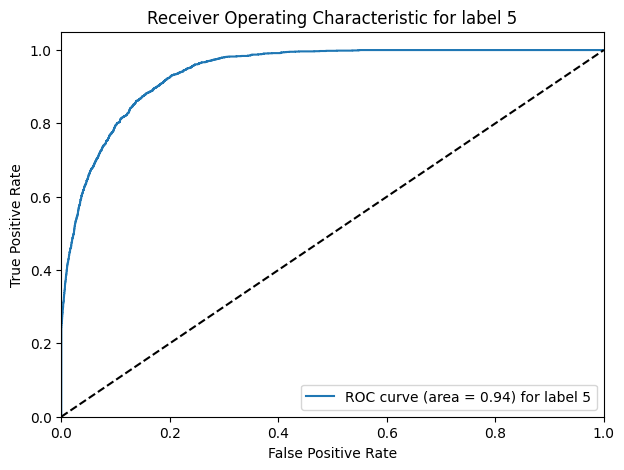

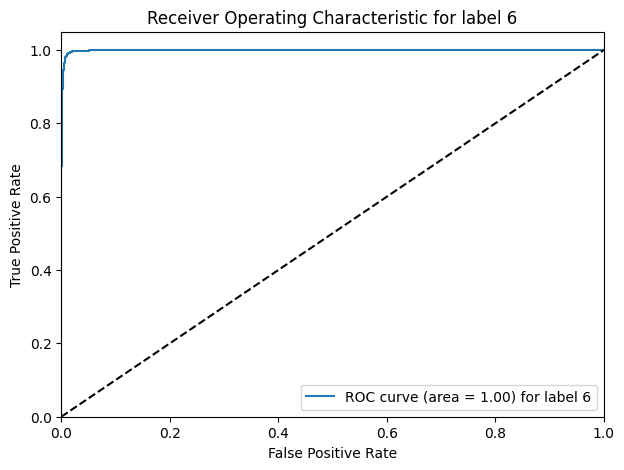

In [57]:
plot_roc_curve(model1, X_test, y_test)

## Save Model

In [58]:
model1.save("ANN_model.keras")

# CNN Model

In [59]:
model2=Sequential()
model2.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model2.add(Dropout(0.2))

model2.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(7, activation='softmax'))

In [60]:
model2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [61]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=3, min_lr=0.0000001)
history2=model2.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/100
 14/631 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.1323 - loss: 1.9454

W0000 00:00:1720884673.398563      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3039 - loss: 1.7062

W0000 00:00:1720884684.936127      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


631/631 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.3040 - loss: 1.7059 - val_accuracy: 0.5001 - val_loss: 1.3014 - learning_rate: 0.0010
Epoch 2/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4811 - loss: 1.3367 - val_accuracy: 0.5456 - val_loss: 1.1696 - learning_rate: 0.0010
Epoch 3/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5376 - loss: 1.1847 - val_accuracy: 0.5602 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 4/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5617 - loss: 1.1214 - val_accuracy: 0.5921 - val_loss: 1.0395 - learning_rate: 0.0010
Epoch 5/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5827 - loss: 1.0800 - val_accuracy: 0.5954 - val_loss: 1.0420 - learning_rate: 0.0010
Epoch 6/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5961 - loss: 1.0393 - val_accuracy: 0.6120 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 7/100
631/631 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6069 - loss: 1.0124 - val

## Evaluate Model

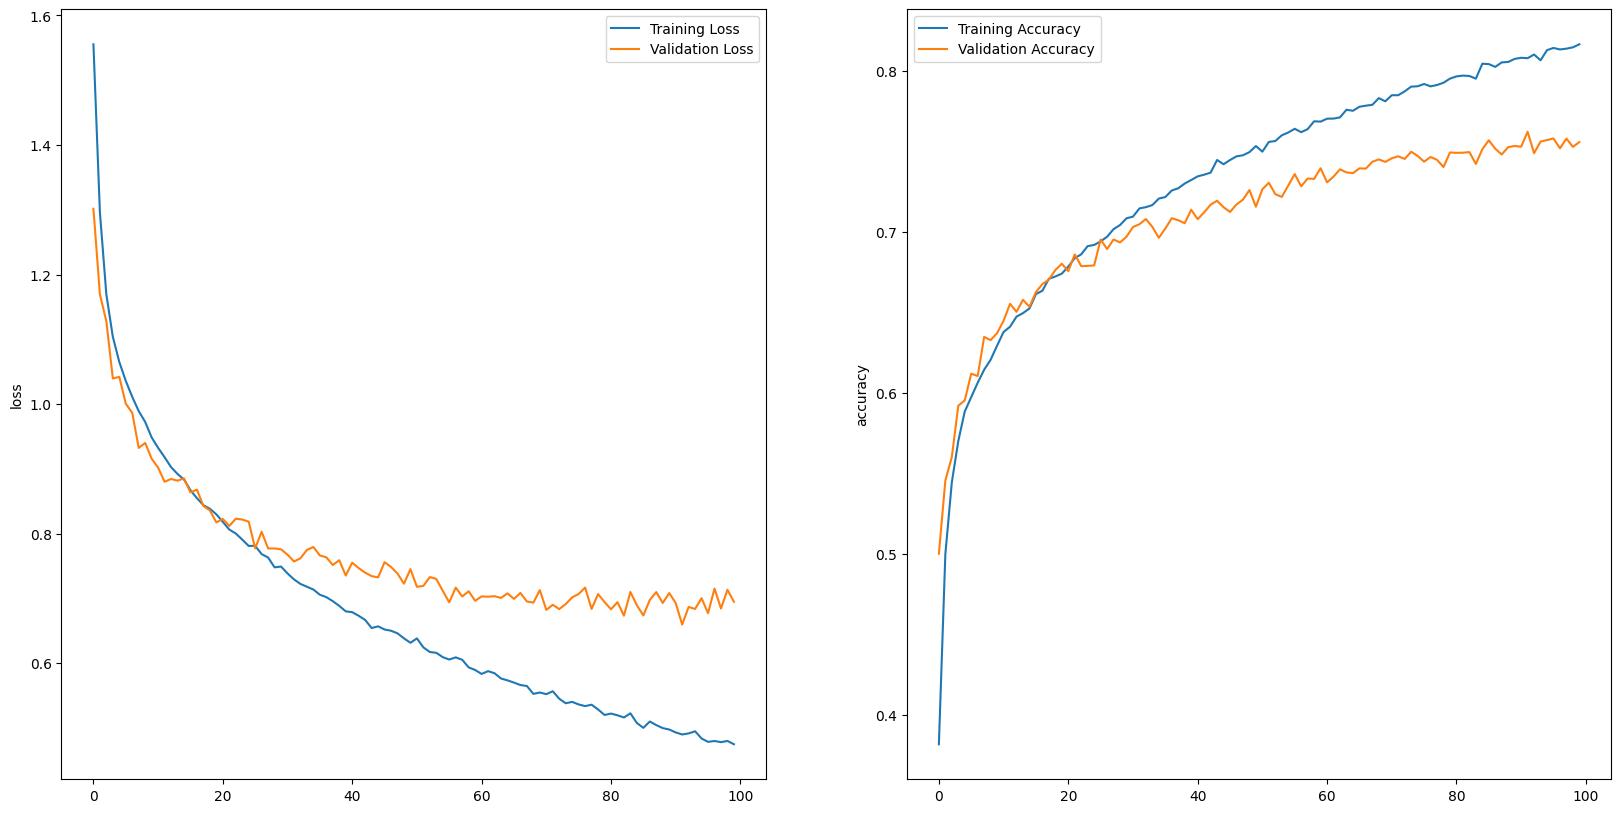

In [62]:
plot_loss_accuracy_curves(history2)

In [63]:
display_metrics(model2, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.6959
Precision: 0.8248
Recall: 0.6959
F1 Score: 0.7514
ROC AUC: 0.9589


421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


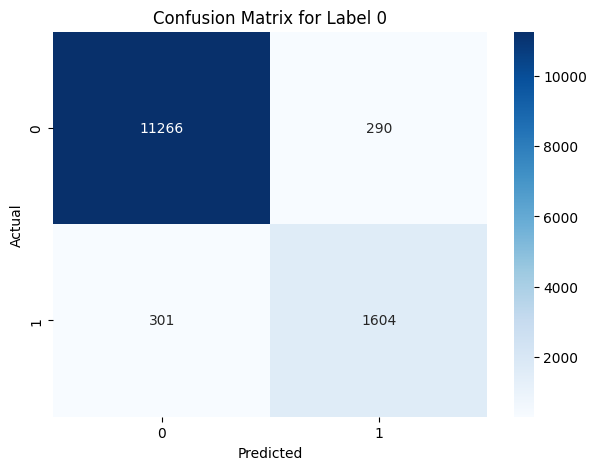

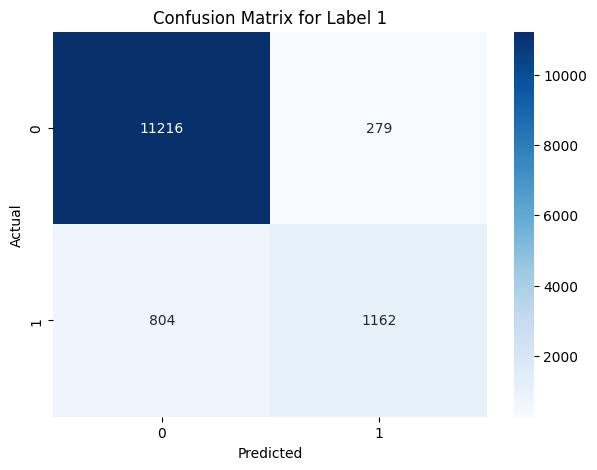

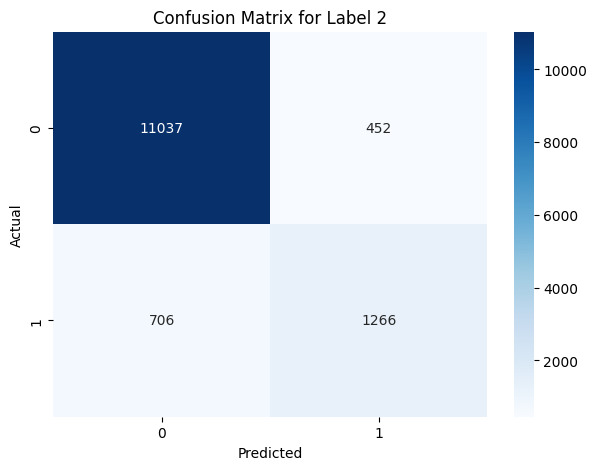

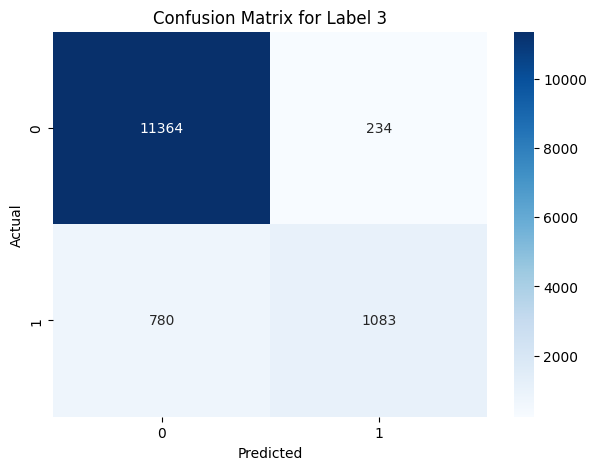

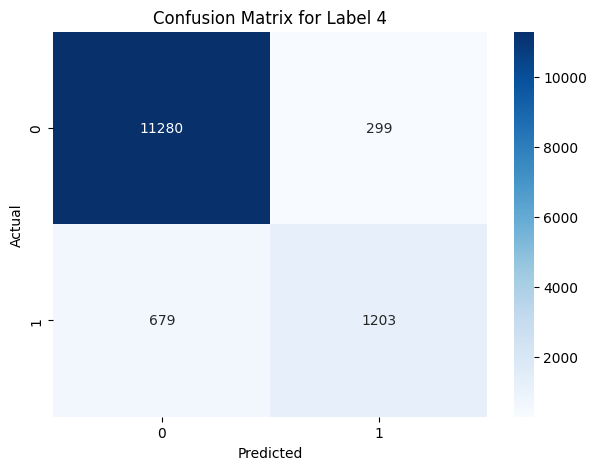

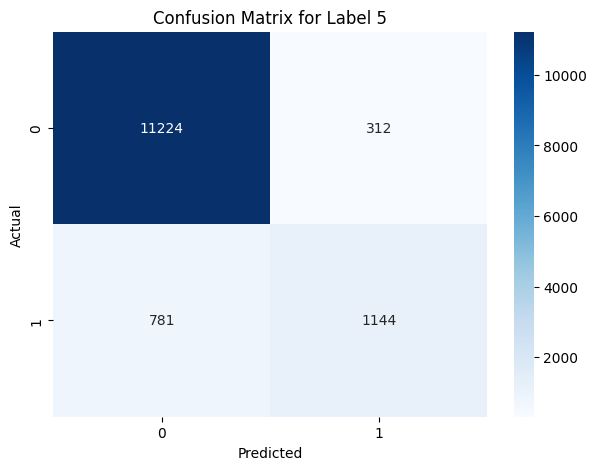

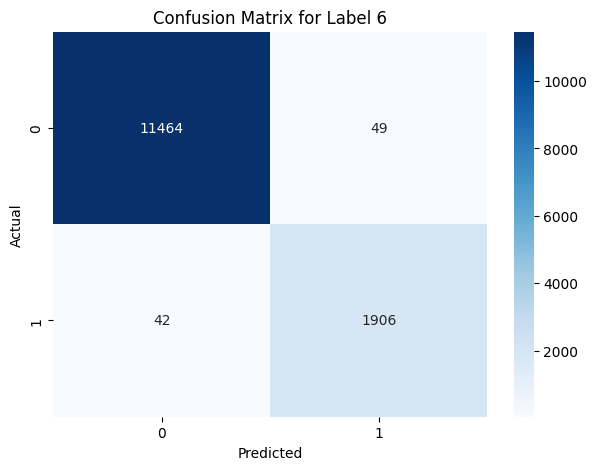

In [64]:
plot_confusion_matrix(model2, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


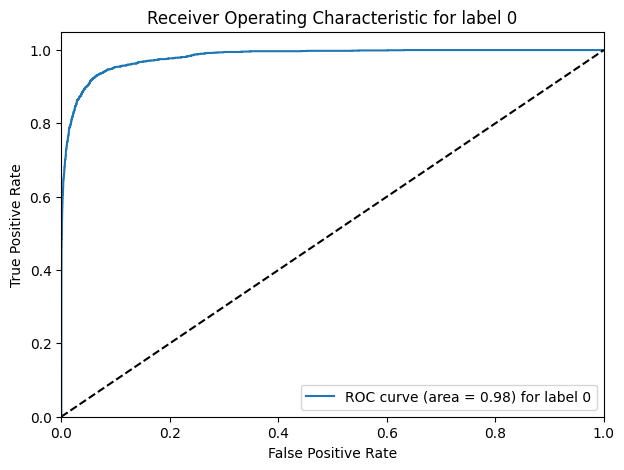

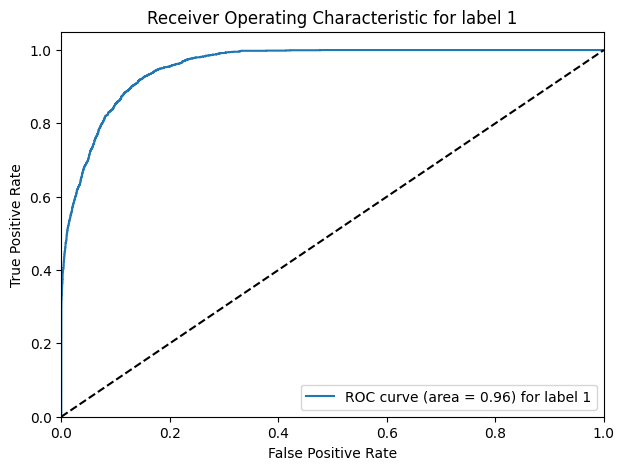

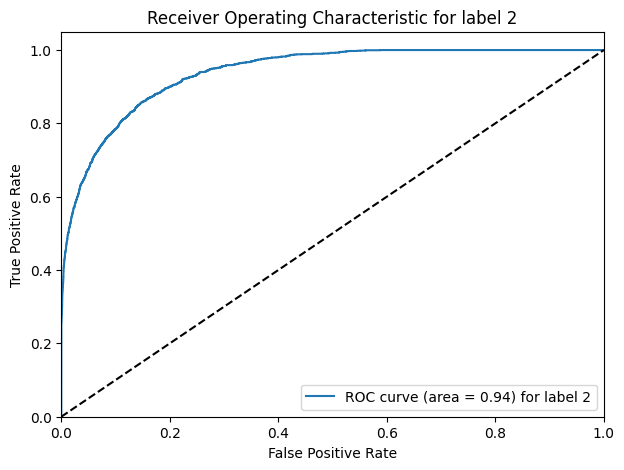

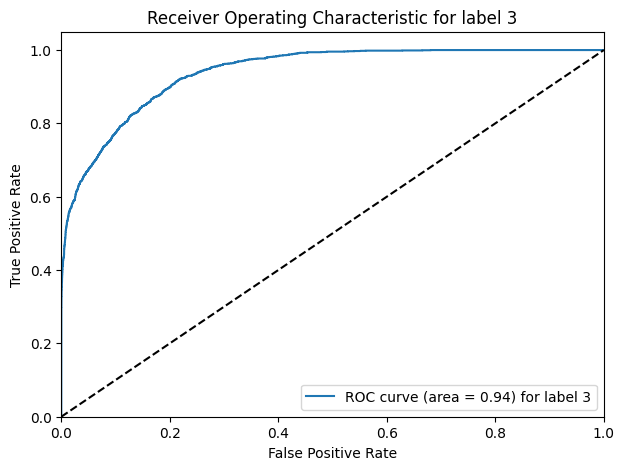

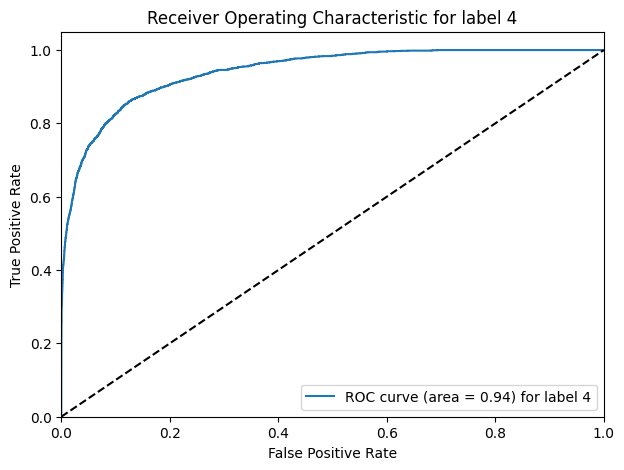

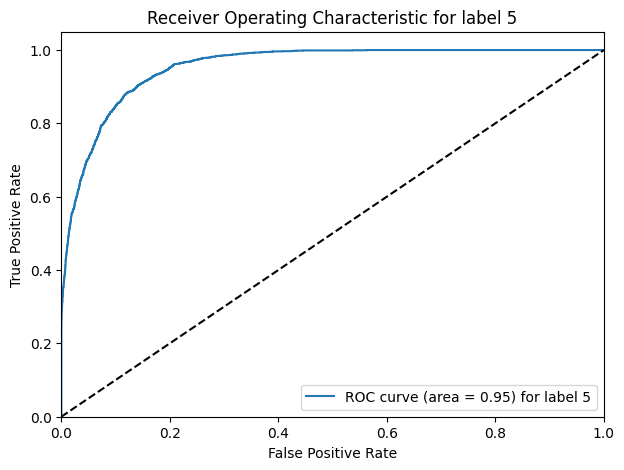

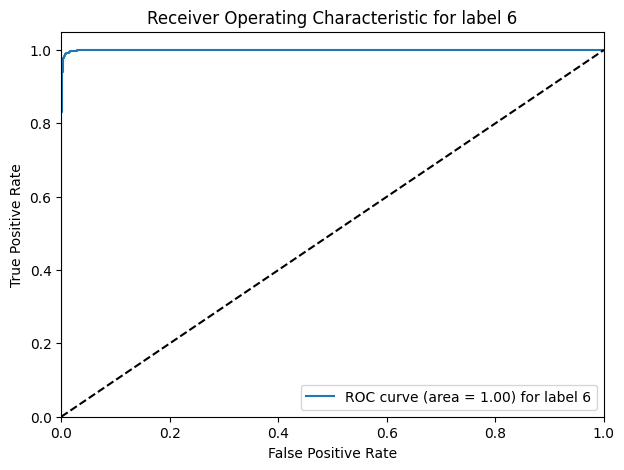

In [65]:
plot_roc_curve(model2, X_test, y_test)

## Save Model

In [66]:
model2.save("CNN_model.keras")

# LSTM Model

In [67]:
model3 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(7, activation="softmax")
])

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history3 = model3.fit(X_train, y_train, epochs=100, batch_size=32, steps_per_epoch=len(X_train)//32, validation_data=(X_test, y_test))

Epoch 1/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.1821 - loss: 1.9309 - val_accuracy: 0.1970 - val_loss: 1.9013
Epoch 2/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1935 - loss: 1.9053 - val_accuracy: 0.1963 - val_loss: 1.9015
Epoch 3/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2180 - loss: 1.8935 - val_accuracy: 0.2288 - val_loss: 1.8684
Epoch 4/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2258 - loss: 1.8540 - val_accuracy: 0.2283 - val_loss: 1.8681
Epoch 5/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.1903 - loss: 1.9303 - val_accuracy: 0.2497 - val_loss: 1.8403
Epoch 6/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1290 - loss: 1.9578 - val_accuracy: 0.2475 - val_loss: 1.8402
Epoch 7/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2414 - loss: 1.8534 - val_accuracy: 0.2988 - val_loss: 1.7667
Epoch 8/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3226 -

## Evaluate model

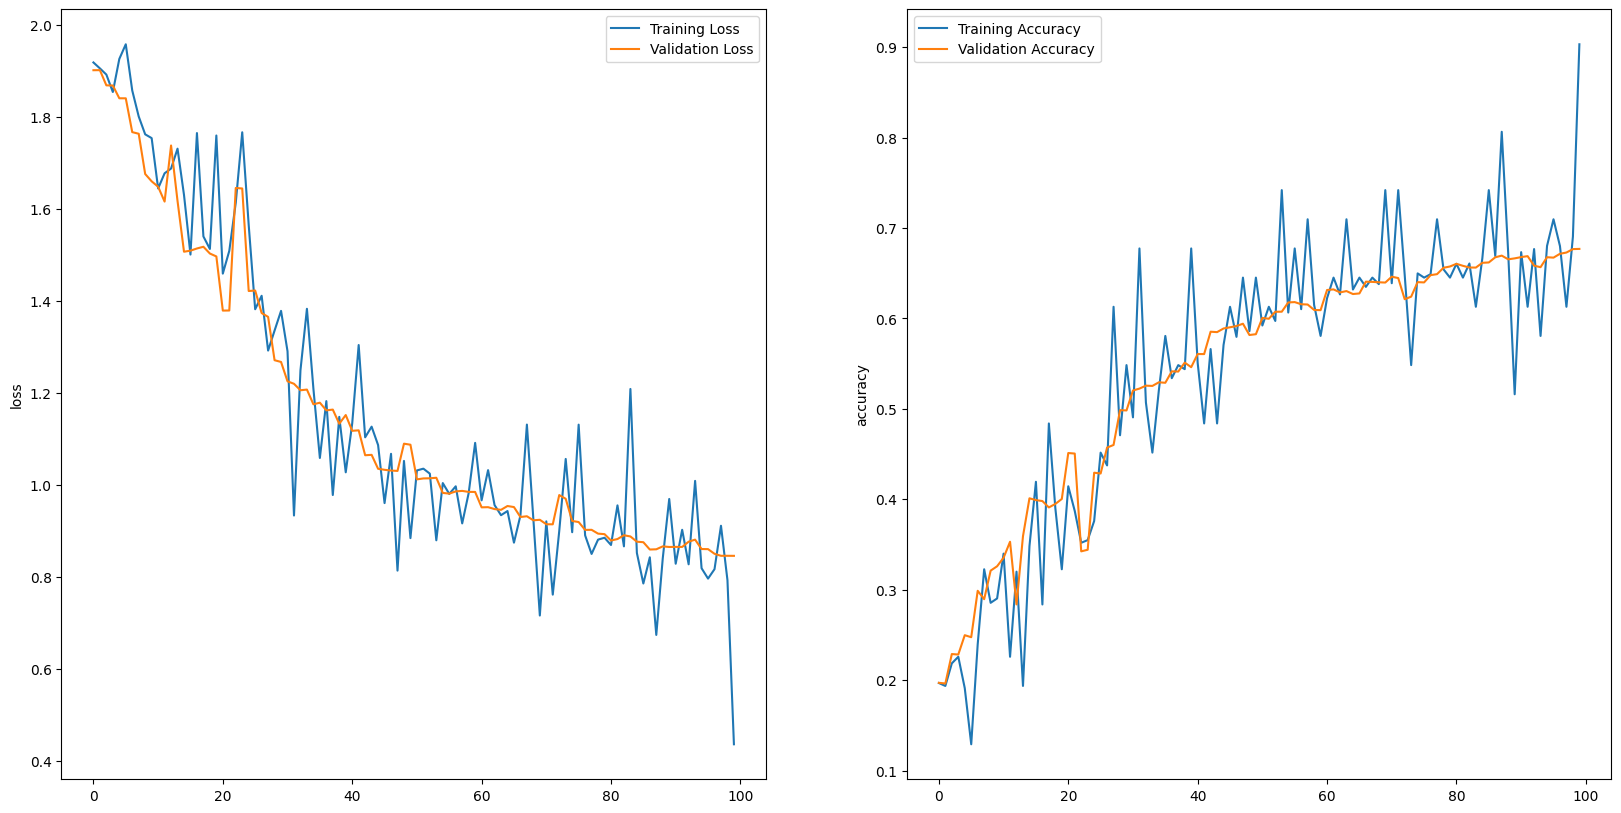

In [68]:
plot_loss_accuracy_curves(history3)

In [69]:
display_metrics(model3, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.5509
Precision: 0.7897
Recall: 0.5509
F1 Score: 0.6400
ROC AUC: 0.9305


421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


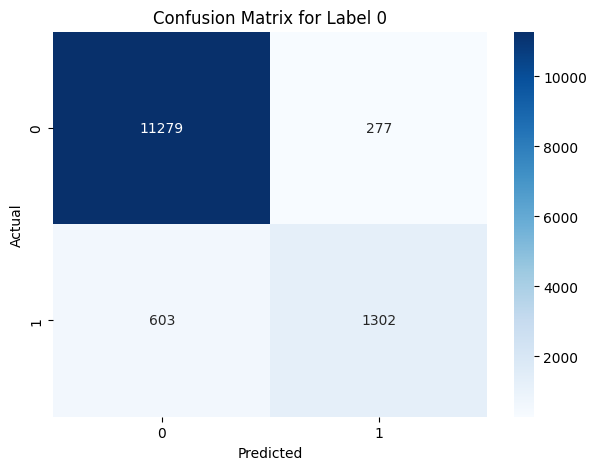

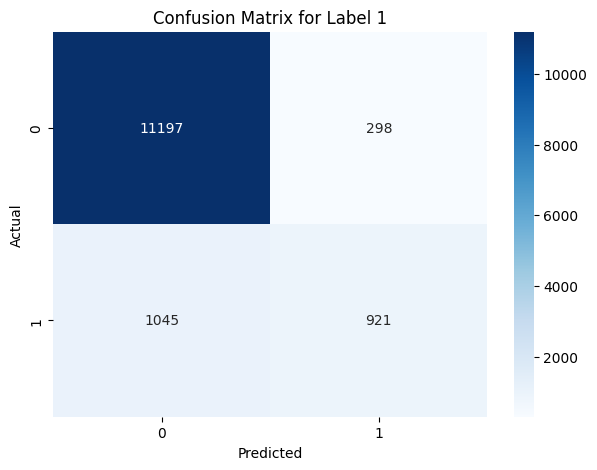

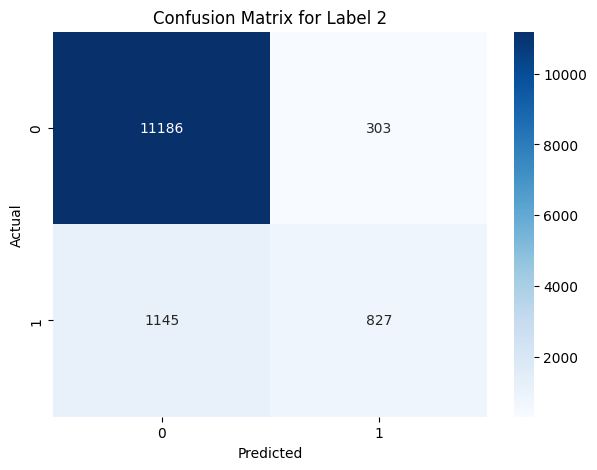

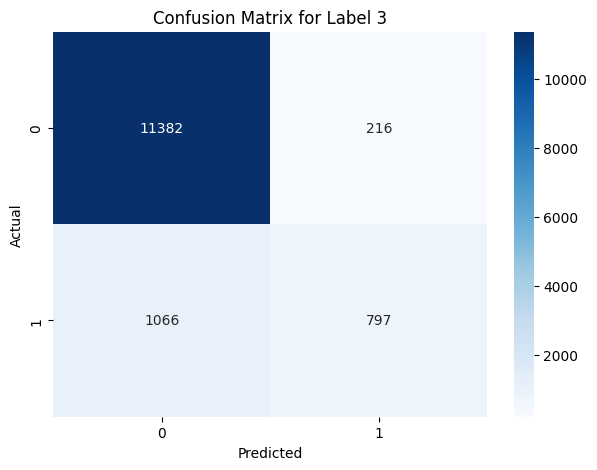

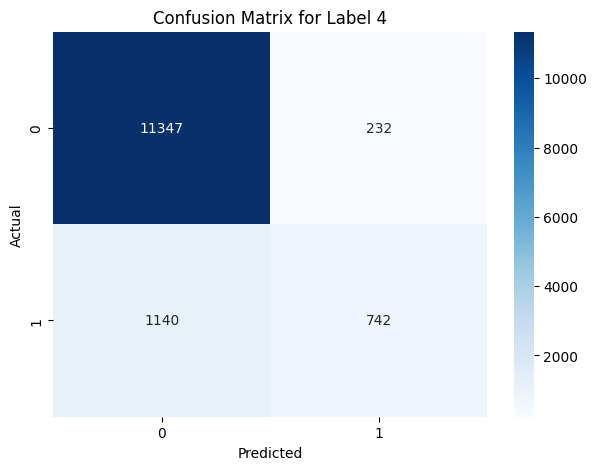

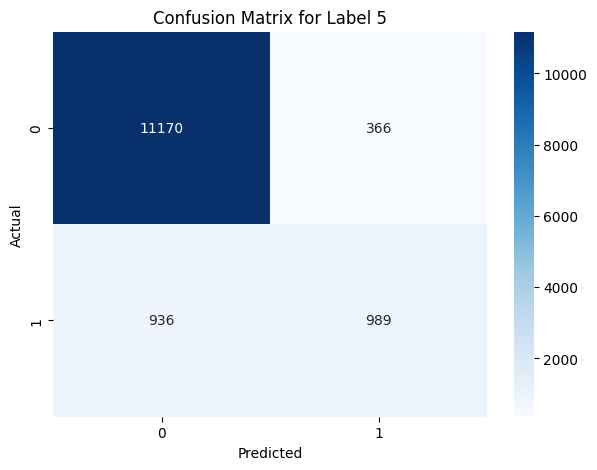

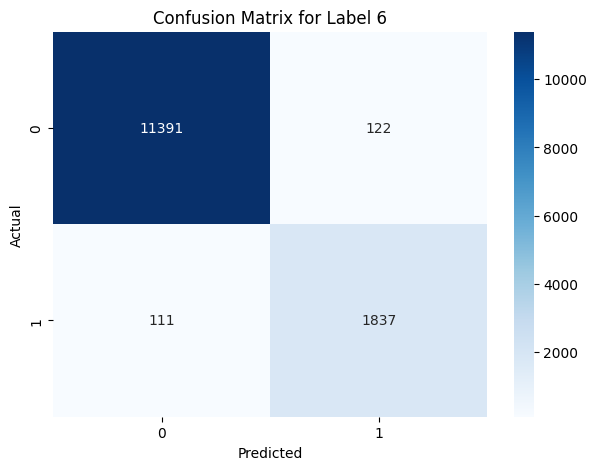

In [70]:
plot_confusion_matrix(model3, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


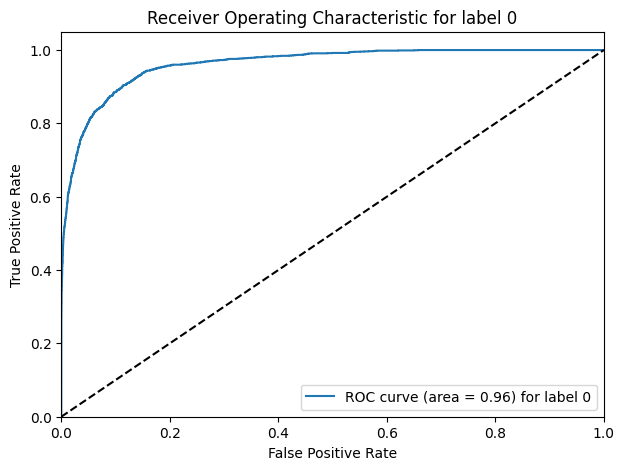

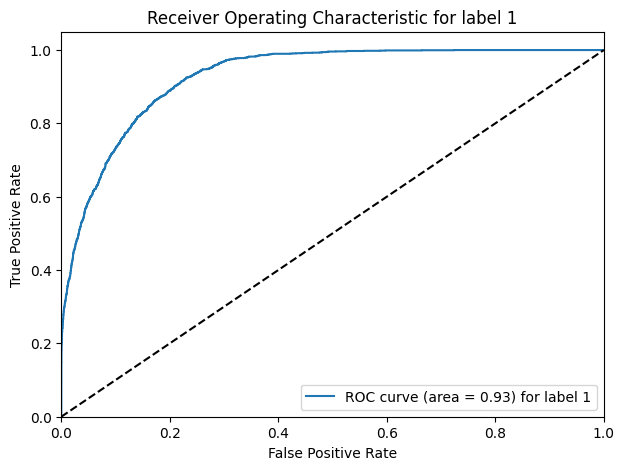

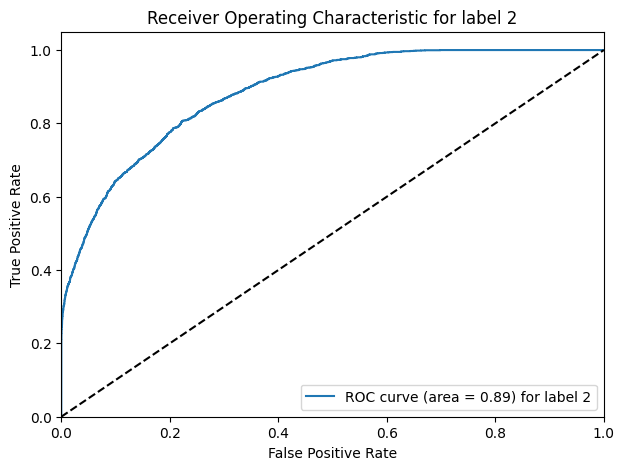

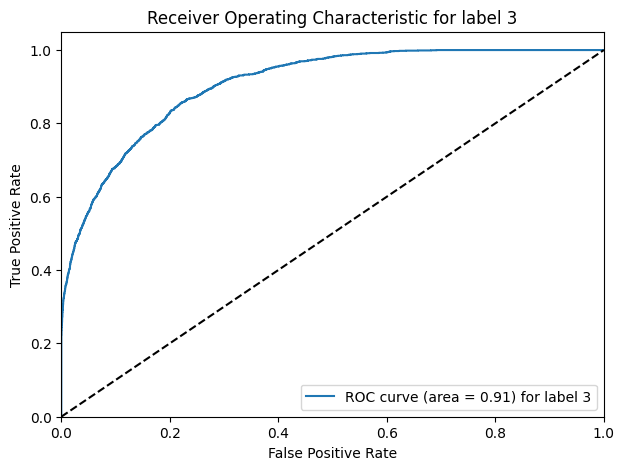

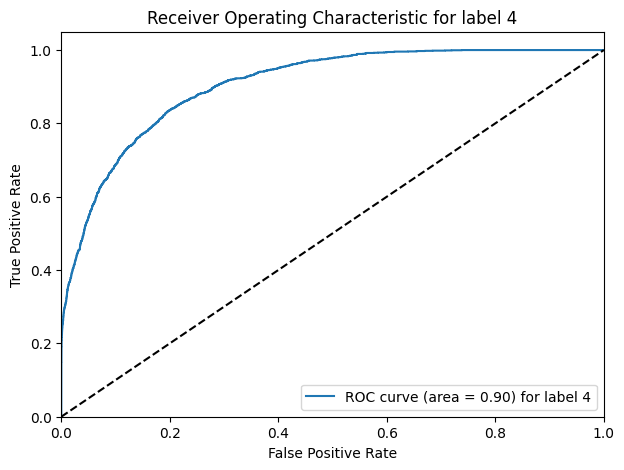

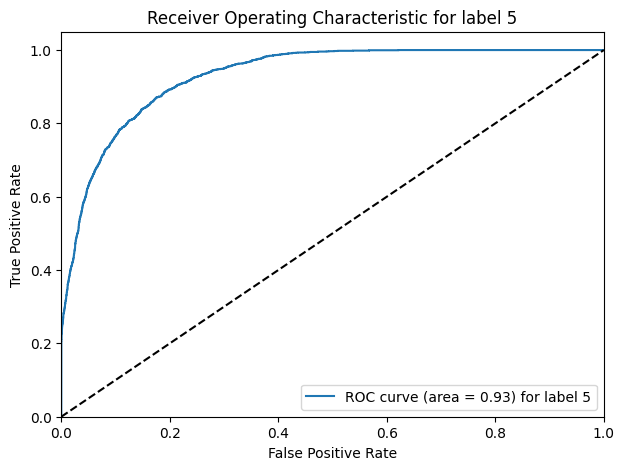

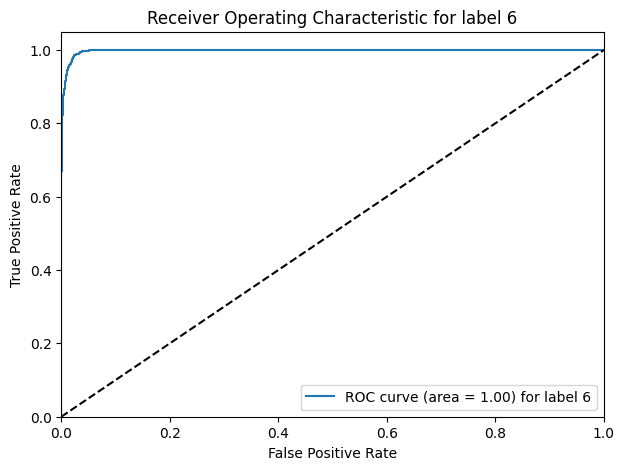

In [71]:
plot_roc_curve(model3, X_test, y_test)

## Save Model

In [72]:
model3.save("LSTM_model.keras")

# CNN-LSTM 


In [73]:
# Define the CNN-LSTM model
model4 = Sequential()

# CNN layers
model4.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model4.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model4.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model4.add(Dropout(0.2))
model4.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# LSTM layers
model4.add(LSTM(128, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(64, return_sequences=False))
model4.add(Dropout(0.2))

# Output layer
model4.add(Dense(7, activation='softmax'))

In [74]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2986 - loss: 1.6984 - val_accuracy: 0.4909 - val_loss: 1.3269
Epoch 2/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4875 - loss: 1.3042 - val_accuracy: 0.5483 - val_loss: 1.1658
Epoch 3/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5346 - loss: 1.1860 - val_accuracy: 0.5904 - val_loss: 1.0557
Epoch 4/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5620 - loss: 1.1190 - val_accuracy: 0.5823 - val_loss: 1.0714
Epoch 5/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5804 - loss: 1.0748 - val_accuracy: 0.5940 - val_loss: 1.0271
Epoch 6/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5926 - loss: 1.0389 - val_accuracy: 0.5988 - val_loss: 1.0224
Epoch 7/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6008 - loss: 1.0227 - val_accuracy: 0.5899 - val_loss: 1.0536
Epoch 8/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 

## Evaluate Model

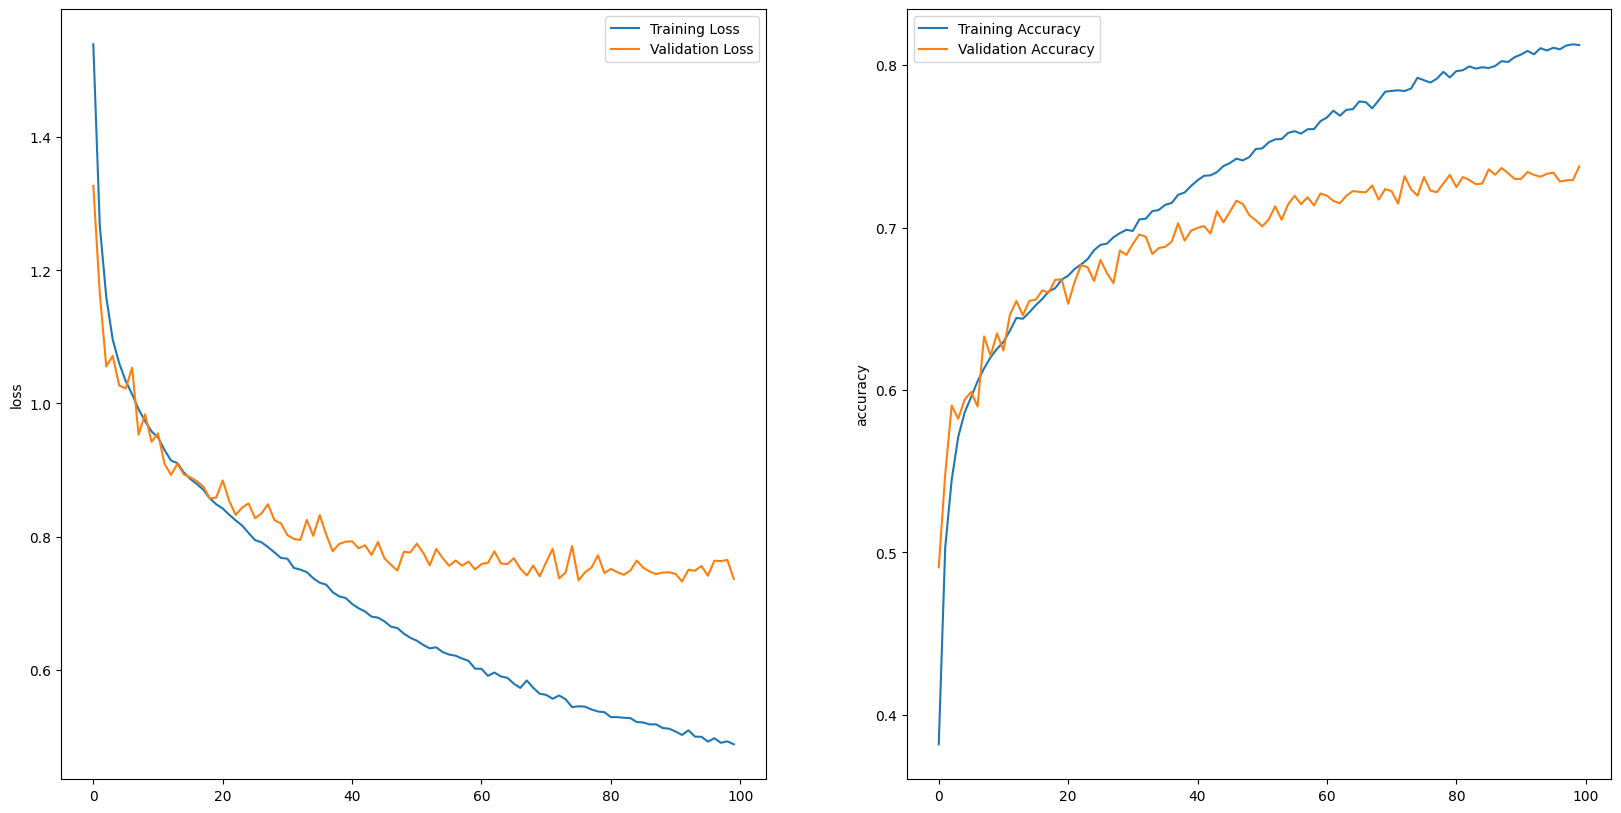

In [76]:
plot_loss_accuracy_curves(history4)

In [77]:
display_metrics(model4, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.6725
Precision: 0.8050
Recall: 0.6725
F1 Score: 0.7283
ROC AUC: 0.9519


421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


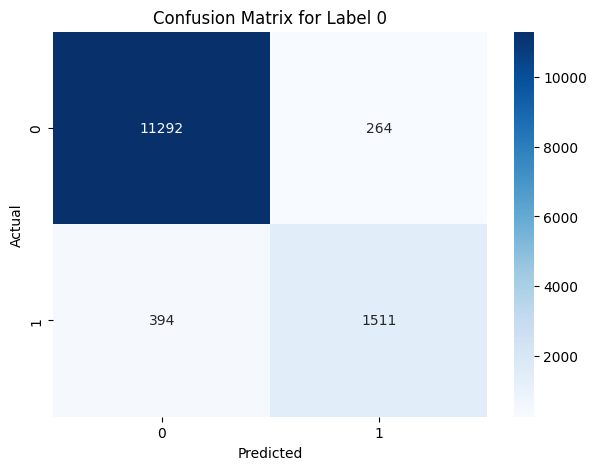

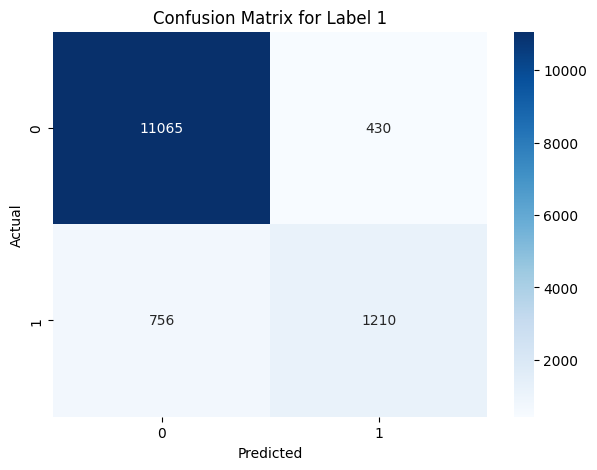

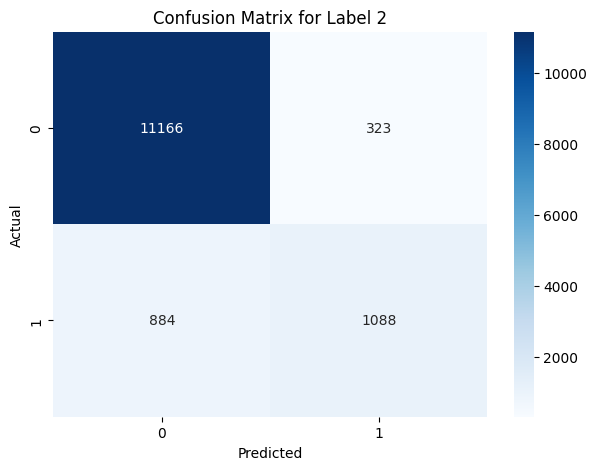

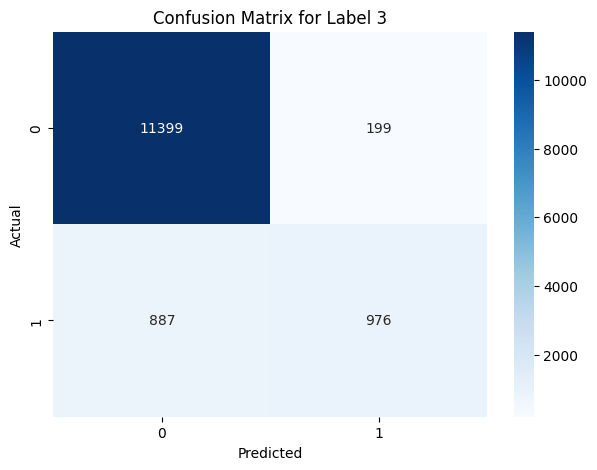

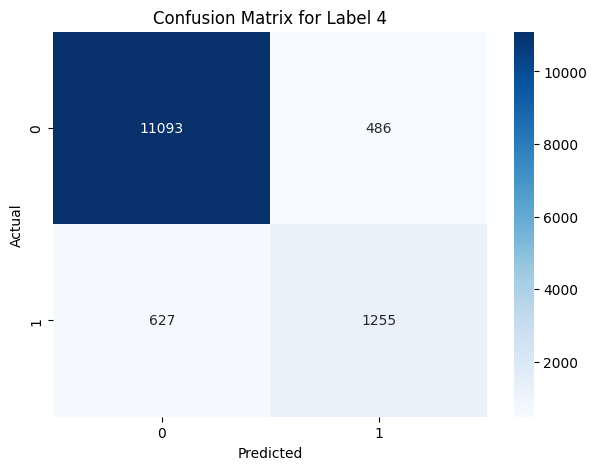

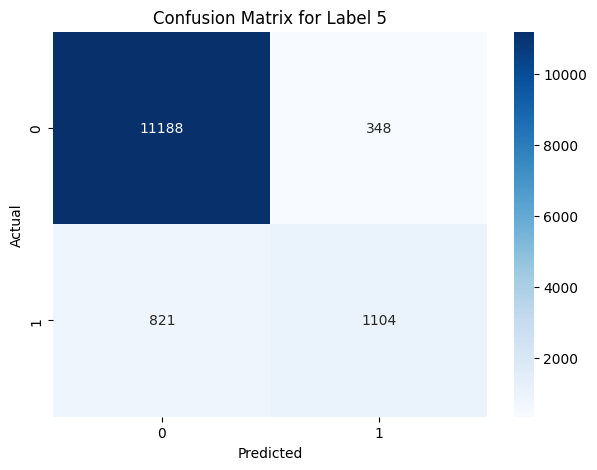

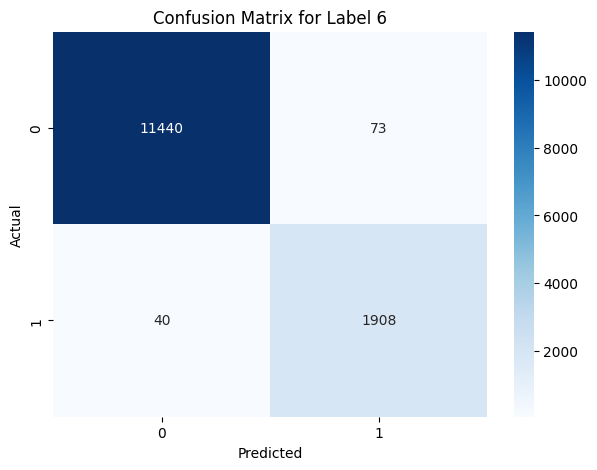

In [78]:
plot_confusion_matrix(model4, X_test, y_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


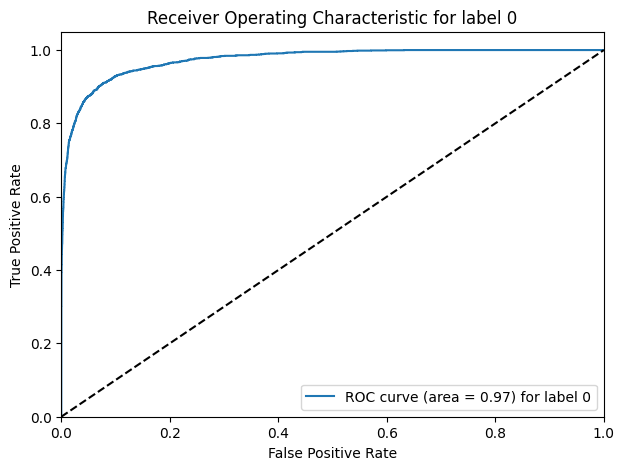

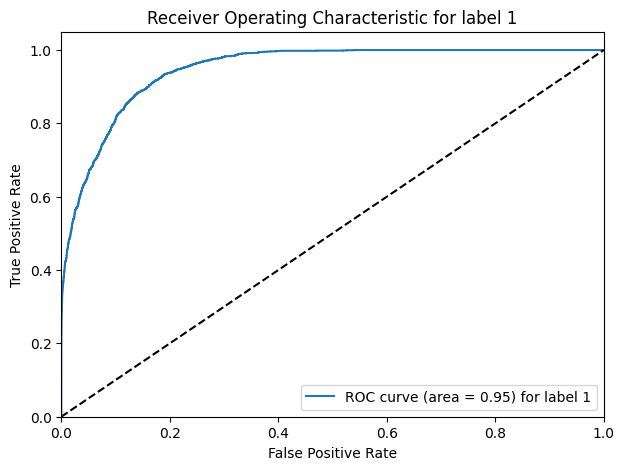

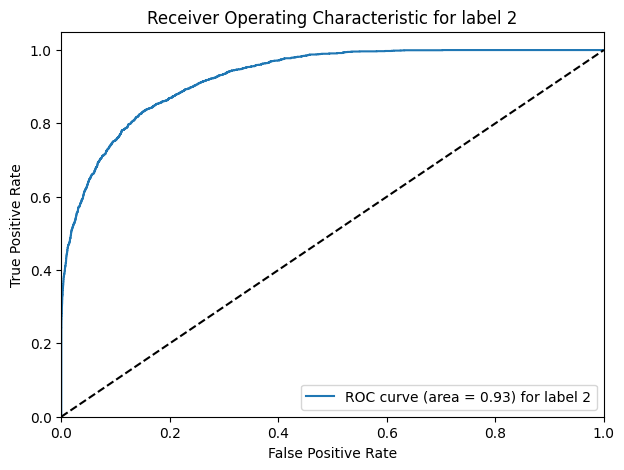

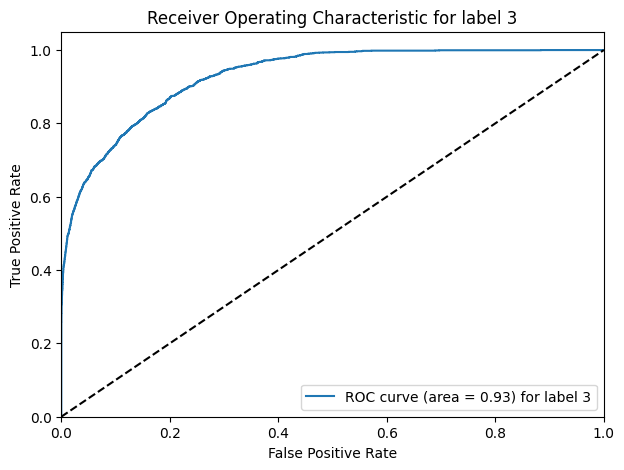

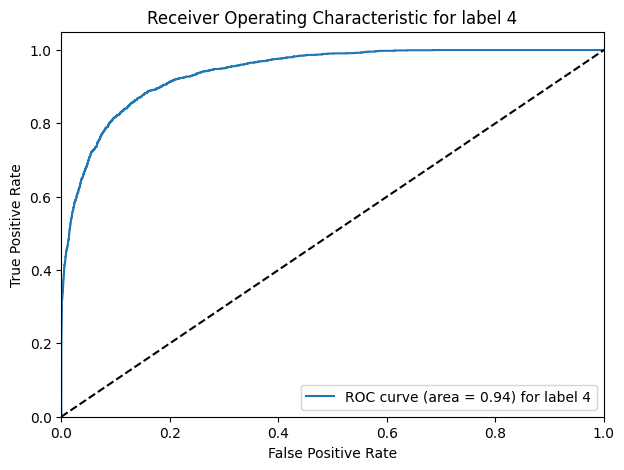

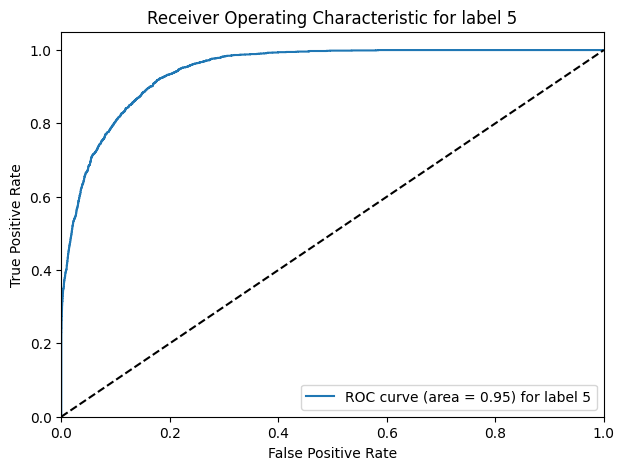

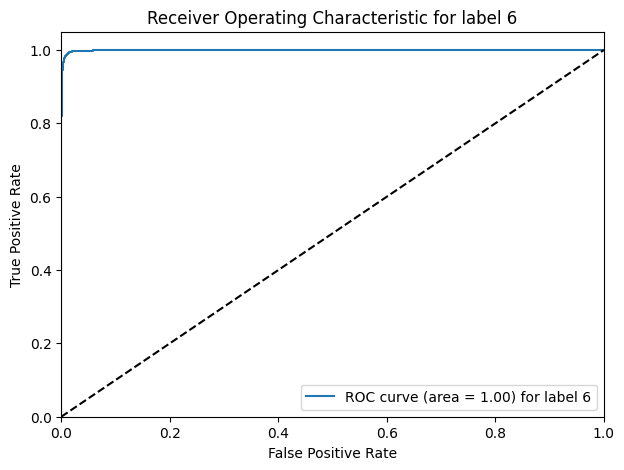

In [79]:
plot_roc_curve(model4, X_test, y_test)

## Save Model

In [80]:
model4.save("CNN_LSTM_model.keras")